In [1]:
import gdown
gdown.download(id='1DDKrNQN0Z-yxvNztOSqGdDkigIx6iqHS')
!unzip 01_Background_and_Theory-20230717T212621Z-001.zip
!rm 01_Background_and_Theory-20230717T212621Z-001.zip
!mv 01_Background_and_Theory Data/
!ls OHBM_Data/01_Background_and_Theory/

Downloading...
From: https://drive.google.com/uc?id=1DDKrNQN0Z-yxvNztOSqGdDkigIx6iqHS
To: /content/01_Background_and_Theory-20230717T212621Z-001.zip
100%|██████████| 576M/576M [00:09<00:00, 62.7MB/s]


Archive:  01_Background_and_Theory-20230717T212621Z-001.zip
   creating: 01_Background_and_Theory/.ipynb_checkpoints/
  inflating: 01_Background_and_Theory/resting_state_fMRI/whobpyt_resting_state_fittingresults_exp.pkl  
  inflating: 01_Background_and_Theory/102513_new_atlas_Yeo.nii.csv  
  inflating: 01_Background_and_Theory/leadfield  
  inflating: 01_Background_and_Theory/resting_state_fMRI/102513_rfMRI_REST2_LR_Schaefer200_cifti_correlated.pconn.nii  
  inflating: 01_Background_and_Theory/resting_state_fMRI/all_centroids.txt  
  inflating: 01_Background_and_Theory/resting_state_fMRI/102513_rfMRI_REST1_LR_Schaefer200_cifti_correlated.pconn.nii  
  inflating: 01_Background_and_Theory/resting_state_fMRI/102513_rfMRI_REST1_RL_Schaefer200_cifti_correlated.pconn.nii  
  inflating: 01_Background_and_Theory/resting_state_fMRI/102513_rfMRI_REST2_RL_Schaefer200_cifti_correlated.pconn.nii  
  inflating: 01_Background_and_Theory/resting_state_fMRI/whobpyt_SC_Schaefer2018_200Parcels_7Networks.

***Dr. Davide Momi***<br/>
​-----------<br/>
Post-Doctoral Research Fellow<br/>
Whole Brain Modelling Group<br/>
Krembil Centre for Neuroinformatics - CAMH<br/>
250 College St., Toronto, ON M5T 1R8<br/>
website: https://davi1990.github.io/<br/>
Twitter: @DaveMomi<br/>
<br/>
<br/>

-----

## Contents


[Overview](#overview)<br/>
[Setup](#setup)<br/>
[Neural mass model of local neural dynamics](#neural-mass-model-of-local-neural-dynamics)<br/>
[Network model of whole-brain anatomical connectivity](#network-model-of-whole-brain-anatomical-connectivity)<br/>
[Conclusions](#conclusions)<br/>
[References](#references)<br/>

## Overview

#### **Introduction**

**Whole-brain models** encompass a collection of equations that depict the dynamics and interplay among neural populations across various brain regions.
These models concentrate on the collective development of a set of important biophysical variables through interconnected differential equations systems (although discrete time step models can also be utilized). These equations can be either formulated based on an understanding of the biophysical mechanisms that underlie diverse brain activities (physiological models), or they can be chosen based on the dynamics they generate (phenomenological models). The local dynamics between different regions are then combined with estimates of anatomical connectivity networks obtained from in vivo measurements. Specifically, statistical observables can be defined using fMRI, EEG, and MEG signals, diffusion tensor imaging (DTI) can provide information about the structural connections between brain regions through whole-brain tractography, and positron emission tomography (PET) imaging can provide insights into metabolism and generate receptor density maps for specific neuromodulators.

Most whole-brain models consist of three fundamental components:

- *Local dynamics:* The activity of each brain region is typically determined by the selected local dynamics along with interaction terms involving other regions (e.g cellular automata, the Ising spin model, autoregressive models, stochastic linear models, non-linear oscillators, neural field theory, neural mass models, and dynamic mean-field models).

- *Brain parcellation:* A brain parcellation determines the number of regions and the spatial resolution at which the brain dynamics occur. This parcellation may include cortical, sub-cortical, and cerebellar regions.

- *Anatomical connectivity matrix:* This matrix defines the network of connections between brain regions. Many studies rely on the human connectome, which is derived by estimating the number of white-matter fibers connecting different brain areas using DTI data combined with probabilistic tractography.


In this course we will mainly focus on neural mass models with few concepts coming from neural field theory.



In this tutorial we will cover some of the key components involved in computational modelling of mesoscopic, whole-brain network dynamics described.

The paradigm we use for mathematically and computationally describing brain organization is called <b>connectome-based neural mass modelling</b>.
Within this framework, the two main components of setting up a whole brain model are

1) **node-level dynamics** <br/>
2) the large-scale **network topology**.<br/>

We will examine each of these in term, for an exemplary neural mass model and brain network connectivity.

This focus is on **resting** or 'steady-state' (as opposed to task- or stimulus-evoked) neural activity, at the relatively **fast timescales** measured by EEG, MEG, ECoG, LFP, etc. (as opposed to slower timescale signals seen in functional MRI).

Demonstrations are done using a combination of pure-python code and simulations run using the [**The Virtual Brain Toolbox (TVB)**](https://thevirtualbrain.org/tvb/zwei) who has the purpose of offering modern tools to the Neurosciences community, for computing, simulating and analyzing functional and structural data of human brains, brains modeled at the level of population of neurons.


## Setup

If you are running this notebook in Google Colab, you will need to install some packages. If you are running in a more standard python environment, you need to ensure that these packages are installed externally (typically with `pip install <package>` on the command line).

In [2]:
import sys
!{sys.executable} -m pip install mne > /dev/null
!{sys.executable} -m pip install nilearn > /dev/null
!{sys.executable} -m pip install nibabel > /dev/null
!{sys.executable} -m pip install tvb-library > /dev/null

import os
#os.chdir('/content/drive/MyDrive')

# @title Install dependencies

In [3]:
from scipy.signal import welch

import nilearn as nl
import nibabel as nib
from scipy.spatial.distance import cdist
import glob
import mne
import os.path as op
from scipy.stats import norm
from scipy import stats
from scipy import signal
from scipy.signal import welch
from scipy.optimize import fsolve
from scipy.io import loadmat
# Suppress warnings; keeps things cleaner
import warnings
warnings.filterwarnings('ignore')

# Standard scientific python import commands
import os,sys,glob,numpy as np,pandas as pd,seaborn as sns
sns.set_style('white')

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle

# TVB stuff
from tvb.simulator.lab import (models,connectivity,coupling,integrators,noise,simulator,
                              surfaces,region_mapping,monitors,equations,patterns,plot_pattern)

from nilearn.image import load_img
from nilearn import plotting as nplot
from nilearn import datasets


import math
from tvb.simulator import models
from tvb.simulator import noise
from ipywidgets import interactive
from ipywidgets import interact, FloatSlider, interactive_output, HBox, VBox


from ipywidgets import interactive, FloatSlider
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# TVB stuff
from tvb.simulator.lab import (models,connectivity,coupling,integrators,noise,simulator,
                              surfaces,region_mapping,monitors,equations,patterns,plot_pattern)

def NormalizeData(data):
         return (data - np.min(data)) / (np.max(data) - np.min(data))


from nilearn import plotting
from tvb.simulator import noise

# @title Importage

## Neural mass model of local neural dynamics

[*Jansen-Rit (1995)*](https://link.springer.com/article/10.1007/BF00199471) is a neural mass model that represents the macroscopic electrophysiological activity within a cortical column. This circuit consists of three interconnected neural populations: one for the pyramidal projection neuron and two for excitatory and inhibitory interneurons, forming two feedback loops.

In the model, each neural population is described with two operators: a rate-to-potential operator describing the dynamics between synapses and dendritic trees, and a potential-to-rate operator representing the output firing rate produced at the soma. The model is thus structured in two steps to describe the populations and capture the dynamics of the circuit.

The first step of the model involves transforming the average pulse density of action potentials received by the population into the average post-synaptic membrane potential. This step is known as the post-synaptic potential block and involves a linear transformation using an impulse response. The impulse response describes the dynamics between the synapses and dendritic trees:
 \begin{equation}
   h(t)=\alpha \beta te^{-\beta t}    \qquad \text{for t} > 0,
 \end{equation}
The variable $\alpha$ is defined as the maximum amplitude of the postsynaptic potential and $\beta$ represent a sum of the reciprocal of the time constant of the passive membrane and all other spatially distributed delays present in the dendritic network, condensed into a single lumped term. For the excitatory  populations $\alpha$, $\beta$ correspond to $A, a$ respectively, and for the inhibitory population $\alpha$, $\beta$ are $B, b$.

 By convolving the incoming pulse with the impulse response, we can determine the relationship between the pulse rate and the corresponding membrane potential, and express it in the form of a second-order differential equation.

The second step transforms the average membrane potential of the population into the average rate of action potentials fired by the neurons using a non-linear operator, and in this case, a sigmoid:
 \begin{equation}
     S(v)=\frac{2e_0}{1+e^{r(V_0-v)}}
 \end{equation}
 with $e_{0}$ representing the maximum firing rate, $r$ denoting the variance of firing thresholds, and $V_{0}$ corresponding to the mean firing threshold.


It is the combination of those two steps that allows the representation of the coarse grained activity of each population in the model. This results in a model with a set of non-linear second-order differential equations that can be re-expressed as sets of first order non-linear ODEs: <br/>
 <br/>
\begin{eqnarray}
    \dot{y}_{0}(t) &=& y_{3}(t)\\
    \dot{y}_{3}(t) &=& AaS[y_{1}(t)-y_{2}(t)] - 2ay_{3}(t) - a^{2}y_{0}(t)\\
    \dot{y}_{1}(t) &=& y_{4}(t)\\
    \dot{y}_{4}(t) &=& Aa(mu(t) + C_{2}S[C_{1}y_{0}(t)]) - 2ay_{4}(t) - a^{2}y_{1}(t)\\
    \dot{y}_{2}(t) &=& y_{5}(t)\\
    \dot{y}_{5}(t) &=& BbC_{4}S[C_{3}y_{0}] - 2by_{5}(t) - b^{2}y_{2}(t)
\end{eqnarray} <br/>
 <br/>
with $mu(t)$ representing the external input to the system, and $C_i$ to the connectivity parameters (See below for graphical representation).

In summary, the Jansen-Rit model captures the dynamics of a local cortico-cortical circuit through a two-step process. It transforms the incoming pulse density into post-synaptic potentials using an impulse response, and then converts the impulse response into a set of differential equations to describe the neural activity of each population. This model provides insights into the complex interactions within the cortical circuitry and aids in understanding the neural dynamics observed in the brain. The output of the pyramidal postsynaptic potentials (y1-y2) is considered as the equivalent of an EEG signal.

![alt text](https://drive.google.com/uc?id=1qBoKEVQi7TCeABtvov6pq_dAu1Ef8-t5)

First we are gonna see the JR implementation in numpy

\begin{equation}
Sigm(\nu) = \frac{2 \nu_{max}}{1 + \exp^{r(\nu_{0} - \nu)}}
\end{equation}

In [4]:
# JR Sigmoid function
def sigm(nu_max,v0,r,v):
  action_potential = (2*nu_max)/(1+np.exp(r*(v0-v)))
  return action_potential

# JR Impulse Response
def imp_Jansen(t,a,b):
  Exc = A*a*t*np.exp(-a*t)
  Inh = B*b*t*np.exp(-b*t)
  return Exc, Inh
def exc_imp_Jansen(t,a,A):
  Exc = A*a*t*np.exp(-a*t)
  return Exc


In [5]:
def plot_exc_impulse_response(A, a):
    t_values = np.arange(0, 0.2, 0.001)
    Exc = [exc_imp_Jansen(t, a, A) for t in t_values]

    plt.figure(figsize=(10, 4))  # Adjust the figsize to your desired width and height

    plt.plot(t_values, Exc)
    plt.xlabel('t')
    plt.ylabel('Excitatory Potential')
    plt.title('Impulse Response')
    plt.grid(True)
    plt.show()

# Define the interactive plot
interactive_plot = interactive(plot_exc_impulse_response, A = (0, 10.0), a=(50, 150))

# Display the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

# @title Interactive_plot

interactive(children=(FloatSlider(value=5.0, description='A', max=10.0), IntSlider(value=100, description='a',…

In [6]:
import matplotlib.pyplot as plt
from ipywidgets import interactive

def plot_sigmoid(nu_max, v0, r):
    v_values = np.linspace(-10, 10, 100)
    action_potentials = [sigm(nu_max, v0, r, v) for v in v_values]

    plt.figure(figsize=(10, 5))  # Adjust the figsize to your desired width and height
    plt.plot(v_values, action_potentials)
    plt.xlabel('v')
    plt.ylabel('Action Potential')
    plt.title('Sigmoid Function')
    plt.grid(True)
    plt.show()

# Define the interactive plot
interactive_plot = interactive(plot_sigmoid, nu_max=(0.1, 10.0), v0=(-10.0, 10.0), r=(0.1, 10.0))

# Display the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '450px'  # Adjust the height as needed
interactive_plot

# @title Interactive_plot

interactive(children=(FloatSlider(value=5.05, description='nu_max', max=10.0, min=0.1), FloatSlider(value=0.0,…

# Available parameters are:

$A$ = Maximum amplitude of EPSP [mV]. Also called average synaptic gain.

$B$ = Maximum amplitude of IPSP [mV]. Also called average synaptic gain.

$a$ = Reciprocal of the time constant of passive membrane and all other spatially distributed delays in the dendritic network [ms^-1]. Also called average synaptic time constant.

$b$ = Reciprocal of the time constant of passive membrane and all
other spatially distributed delays in the dendritic network [ms^-1].
Also called average synaptic time constant.

$v_0$ = Firing threshold (PSP) for which a 50% firing rate is achieved.In other words, it is the value of the average membrane potential corresponding to the inflection point of the sigmoid [mV]. The usual value for this parameter is 6.0.

$\nu_{max}$ = Determines the maximum firing rate of the neural population [s^-1].

$r$ = Steepness of the sigmoidal transformation [mV^-1].

$J$ = Average number of synapses between populations.

$a_1$ = Average probability of synaptic contacts in the feedback excitatory loop.

$a_2$ = Average probability of synaptic contacts in the slow feedback excitatory loop.

$a_3$ = Average probability of synaptic contacts in the feedback inhibitory loop.

$a_4$ = Average probability of synaptic contacts in the slow feedback inhibitory loop.

$p_{min}$ = Minimum input firing rate.

$p_{max}$ = Maximum input firing rate.

$\mu$ = Mean input firing rate

In [7]:
# Parameter settings
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = 0.25*C
C4 = 0.25*C
v0 = 6         # mV
tau_e = 10
tau_i = 20
a = (1/tau_e)*1000 # 100        # s^-1
b = (1/tau_i)*1000 # 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1

# Simulation setting
start = 0.0
stim_time =10
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)

# Input
noise = np.random.uniform(120,320,vec_len)

# Output Initialization
y = np.zeros((6,vec_len))

The equations of the Jansen-Rit model are the following:
\begin{equation*}
    \begin{split}
        \dot{y_{0}} &= y_{3} \\
        \dot{y_{3}} &= Aa Sigm(y_{1} -  y_{2}) - 2a y_{3} - a^{2} y_{0} \\
        \dot{y_{1}} &= y_{4} \\
        \dot{y_{4}} &= Aa [p(t) + \alpha_2 J Sigm[\alpha_1 J y_0] + lrc + src] -2a y_{4} - a^{2} y_{1}\\
        \dot{y_{2}} &= y_{5} \\
        \dot{y_5}   &= Bb (\alpha_4 J Sigm[\alpha_3 J y_{0}]) - 2b y_{5} - b^{2} y_{2} \\
    \end{split}
\end{equation*}

In [8]:
# Euler integration method to solve JR differential equations
for i in range (1,vec_len):
  y[0,i] = y[0,i-1] + y[3,i-1]*dt
  y[1,i] = y[1,i-1] + y[4,i-1]*dt
  y[2,i] = y[2,i-1] + y[5,i-1]*dt
  y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
  y[4,i] = y[4,i-1] + dt * (A*a*(noise[i-1] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
  y[5,i] = y[5,i-1] + dt * (B*b*(C4*sigm(nu_max,v0,r,(C3*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))

output = y[1,:]-y[2,:]
X = signal.resample(output, 10000)
freqs_Jansen,ps_vPN_Jansen = welch(X,fs=1000, noverlap = 125, nperseg=1000)

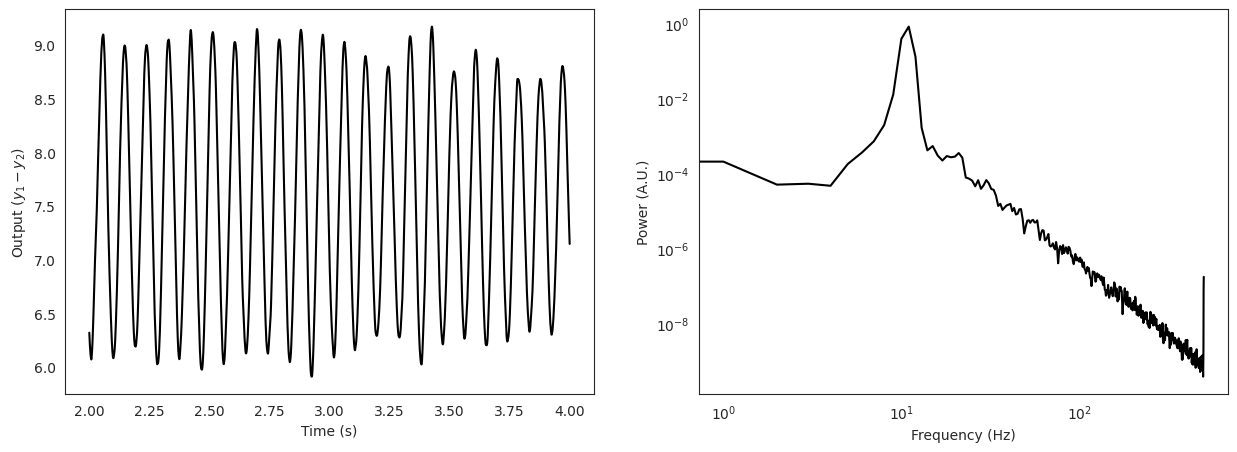

In [9]:
# Figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax2.set_xscale("log")
ax2.set_yscale("log")
ax1.plot(time_array[20000:40000],output[20000:40000], color='black')
ax1.set_xlabel('Time (s)')
ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Output ($y_{1}-y_{2}$)')
ax2.set_ylabel('Power (A.U.)')
ax2.plot(freqs_Jansen,ps_vPN_Jansen, color='black')

This can also be performed by tvb...

In [10]:
# Run JR single node in TVB

n_step = 50000
dt = 0.1

# Define initial conditions
initconds = np.array([-4.,-4.,-4.,-4.,-4.,-4.])[:,np.newaxis]

# fixed params for these examples : oscillatory
a= np.array([0.1])#[0.029])
mu = np.array([0.22])#0.1085])
b = np.array([0.05])
# Initialize model instance with fixed params
mod = models.JansenRit(v0=np.array([6.]), mu=mu, p_max=mu, p_min=mu,
                       b = b, a =a)

# Execute single-node simulation run
time,dat = mod.stationary_trajectory(n_step=n_step,dt=dt)
y_0 = np.squeeze(dat[:,0,:,:])
y_1 = np.squeeze(dat[:,1,:,:])
y_2 = np.squeeze(dat[:,2,:,:])


freqs_Jansen_tvb,ps_vPN_Jansen_tvb = welch((y_1-y_2)[1000:],fs=1000, noverlap = 125, nperseg=1000)


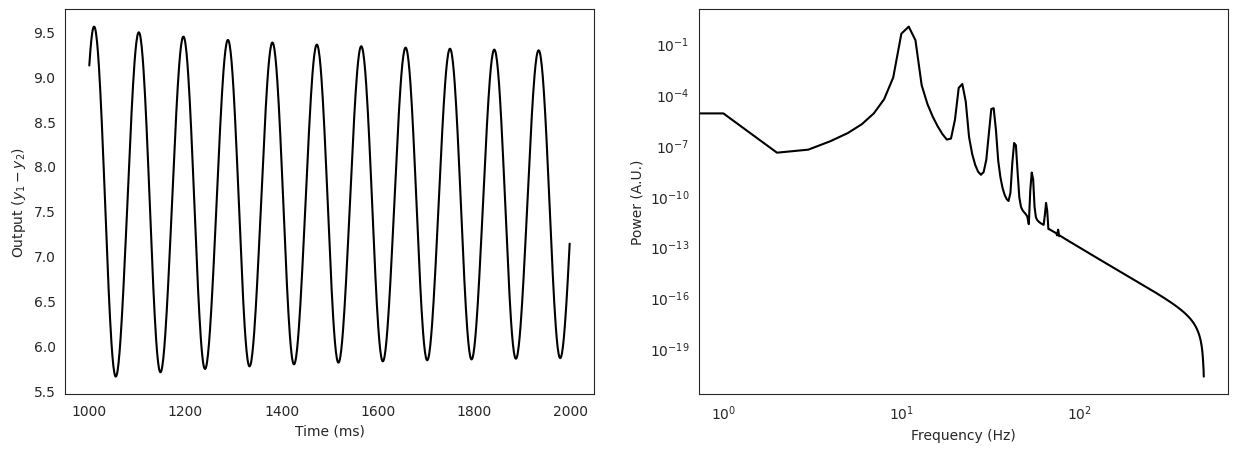

In [11]:
# Figures


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax2.set_xscale("log")
ax2.set_yscale("log")
ax1.plot(time[1000:2000],(y_1-y_2)[1000:2000], color='black')
ax1.set_xlabel('Time (ms)')
ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Output ($y_{1}-y_{2}$)')
ax2.set_ylabel('Power (A.U.)')
ax2.plot(freqs_Jansen_tvb,ps_vPN_Jansen_tvb, color='black')

In the following code cell, we will explore the impact of different values of $mu$ (representing noise/external input) on the output of the single node model we previously created. We will focus specifically on sliding the $mu$ parameter and observe how it affects the generation of alpha oscillations, with the original optimal value of 0.22 as a reference ([Jansen & Rit 1995](https://pubmed.ncbi.nlm.nih.gov/7578475/))

In [12]:
# Define the parameter range for bifurcation diagram
mu_range = np.linspace(0, 0.6, 100)


def simulate_and_plot(mu):
    # Run JR single node in TVB
    n_step = 50000
    dt = 0.1

    # Define initial conditions
    initconds = np.array([-4., -4., -4., -4., -4., -4.])[:, np.newaxis]

    # fixed params for these examples: oscillatory
    a = np.array([0.1])
    b = np.array([0.05])

    # Initialize model instance with variable mu
    mod = models.JansenRit(v0=np.array([6.]), mu=np.array([mu]), p_max=np.array([mu]),
                           p_min=np.array([mu]), b=b, a=a)

    # Execute single-node simulation run
    time, dat = mod.stationary_trajectory(n_step=n_step, dt=dt)
    y_0 = np.squeeze(dat[:, 0, :, :])
    y_1 = np.squeeze(dat[:, 1, :, :])
    y_2 = np.squeeze(dat[:, 2, :, :])

    freqs_Jansen_tvb, ps_vPN_Jansen_tvb = welch((y_1 - y_2)[1000:], fs=1000, noverlap=125, nperseg=1000)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax1.plot(time[1000:2000], (y_1 - y_2)[1000:2000], color='black')
    ax1.set_xlabel('Time (ms)')
    ax2.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Output ($y_{1}-y_{2}$)')
    ax2.set_ylabel('Power (A.U.)')
    ax2.plot(freqs_Jansen_tvb, ps_vPN_Jansen_tvb, color='black')
    plt.show();

# Create an interactive slider for the parameter mu
mu_slider = FloatSlider(min=0, max=0.6, step=0.01, value=0.2, description='mu')

# Define the interactive function
interactive_plot = interactive(simulate_and_plot, mu=mu_slider)

# Display the interactive plot
interactive_plot

# @title Interactive_plot

interactive(children=(FloatSlider(value=0.2, description='mu', max=0.6, step=0.01), Output()), _dom_classes=('…

### **Phase plane analysis**

So far, we have plotted the activities of the two populations as a function of time, i.e., in the `Activity-t` plane, either the $(t, y_1(t)-y_2(t))$. We also have plotted the corresponding time-frequency representation of this time-wise activity using `welch` decomposition.


Now instead, we can plot the two activities $y_0(t)$,  $y_1(t)$ and $y_2(t)$ against each other at any time point $t$. This characterization in the `y_0-y_1-y_2` plane $(y_0(t), y_1(t), y_2(t))$ is called the **phase plane**. Each line in the phase plane indicates how $y_0$, $y_1$ and $y_2$ evolve with time.

For example, we can visualize how these trajectories changes depending on the variables used. To illustrate that, we present here how the evolution of the variables can change when the connectivity parameter between the pyramidal cells and the inhibitory interneurons is different.

When a variable parameter changes, the dynamics are affected. For example, in the cell below we are going to explore how varying the noise/external input $mu$ will affect the system dynamics.

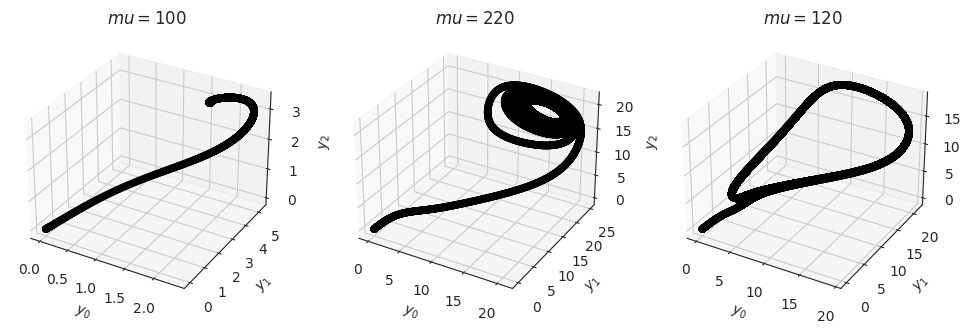

In [13]:
# Parameter settings
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = 0.25*C
C4 = 0.25*C
v0 = 6         # mV
tau_e = 10
tau_i = 20
a = (1/tau_e)*1000 # 100        # s^-1
b = (1/tau_i)*1000 # 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1

# Simulation setting
start = 0.0
stim_time =10
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)

# For simplicity, we set the noise as a constant
mu  = [100, 220, 120]

# Output Initialization
y = np.zeros((6,vec_len))
res_y0 = []
res_y1 = []
res_y2 = []

# Euler integration method to solve JR differential equations
for j in range(0,len(mu)):
  for i in range (1,vec_len):
    y[0,i] = y[0,i-1] + y[3,i-1]*dt
    y[1,i] = y[1,i-1] + y[4,i-1]*dt
    y[2,i] = y[2,i-1] + y[5,i-1]*dt
    y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
    y[4,i] = y[4,i-1] + dt * (A*a*(mu[j] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
    y[5,i] = y[5,i-1] + dt * (B*b*(C4*sigm(nu_max,v0,r,(C3*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))
  res_y0.append(y[0,:].copy())
  res_y1.append(y[1,:].copy())
  res_y2.append(y[2,:].copy())

# Create the 3D plot
%matplotlib inline
# Create the figure and subplots
fig = plt.figure(figsize=(12, 4))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(C*res_y0[0], res_y1[0], res_y2[0], marker='o', color='black')
# Set labels and title
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('$y_1$')
ax1.set_zlabel('$y_2$')
ax1.set_title('$mu=100$')

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(C*res_y0[1], res_y1[1], res_y2[1], marker='o', color='black')
# Set labels and title
ax2.set_xlabel('$y_0$')
ax2.set_ylabel('$y_1$')
ax2.set_zlabel('$y_2$')
ax2.set_title('$mu=220$')


# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(C*res_y0[2], res_y1[2], res_y2[2], marker='o', color='black')
# Set labels and title
ax3.set_xlabel('$y_0$')
ax3.set_ylabel('$y_1$')
ax3.set_zlabel('$y_2$')
ax3.set_title('$mu=120$')

# Show the plot
plt.show()

In the first plot (left side), the system initially exhibits a single impulse and then converges to a stable point. Once the equilibrium or stable fixed point is reached, the system remains at that value. By increasing the value of $mu$ (representing noise/external input), the system undergoes a transition. Beyond a certain threshold, the system starts to exhibit oscillatory behavior with varying frequencies. These oscillations become larger and longer in duration, as seen in the central and right plots, respectively. Similar changes in dynamics can be observed by altering the input term.

The key question is: how can we understand and predict these dynamics? To answer this question, we employ stability and bifurcation analysis. These analytical techniques help us examine the stability of equilibrium points and understand how the system's behavior changes as the parameters, such as mu, are varied.

The same plots can be realized by varying the $C3$ and $C4$

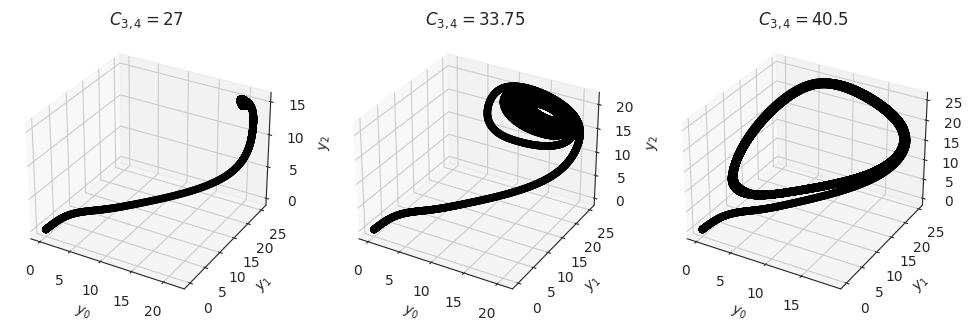

In [ ]:
# Parameter settings
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = [0.2*C, 0.25*C, 0.3*C]
C4 = [0.2*C, 0.25*C, 0.3*C]
v0 = 6         # mV
tau_e = 10
tau_i = 20
a = (1/tau_e)*1000 # 100        # s^-1
b = (1/tau_i)*1000 # 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1

# Simulation setting
start = 0.0
stim_time =10
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)

# Input
noise = np.random.uniform(120,320,vec_len)

# Output Initialization
y = np.zeros((6,vec_len))
res_y0 = []
res_y1 = []
res_y2 = []

# Euler integration method to solve JR differential equations
for j in range(0,len(C3)):
  for i in range (1,vec_len):
    y[0,i] = y[0,i-1] + y[3,i-1]*dt
    y[1,i] = y[1,i-1] + y[4,i-1]*dt
    y[2,i] = y[2,i-1] + y[5,i-1]*dt
    y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
    y[4,i] = y[4,i-1] + dt * (A*a*(noise[i-1] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
    y[5,i] = y[5,i-1] + dt * (B*b*(C4[j]*sigm(nu_max,v0,r,(C3[j]*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))
  res_y0.append(y[0,:].copy())
  res_y1.append(y[1,:].copy())
  res_y2.append(y[2,:].copy())

# Create the 3D plot
%matplotlib inline
# Create the figure and subplots
fig = plt.figure(figsize=(12, 4))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(C*res_y0[0], res_y1[0], res_y2[0], marker='o', color='black')
# Set labels and title
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('$y_1$')
ax1.set_zlabel('$y_2$')
ax1.set_title('$C_{3,4} = 27$')

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(C*res_y0[1], res_y1[1], res_y2[1], marker='o', color='black')
# Set labels and title
ax2.set_xlabel('$y_0$')
ax2.set_ylabel('$y_1$')
ax2.set_zlabel('$y_2$')
ax2.set_title('$C_{3,4} = 33.75$')


# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(C*res_y0[2], res_y1[2], res_y2[2], marker='o', color='black')
# Set labels and title
ax3.set_xlabel('$y_0$')
ax3.set_ylabel('$y_1$')
ax3.set_zlabel('$y_2$')
ax3.set_title('$C_{3,4} = 40.5$')

# Show the plot
plt.show()

# Stability analysis

For this part we are going to go through the stability analysis of the system as a function of the input $mu$ which a detailed analysis is also shown in "Bifurcation Analysis of Jansen's Neural Mass Model" by François Grimbert, Olivier Faugeras (https://pubmed.ncbi.nlm.nih.gov/17052158/).

We can get an idea of the effect of $mu$ by looking at $y_{1}-y_{2}$ (voltage contribution) against $y_{4}-y_{5}$ (current contribution) as a function of $mu$


![alt text](https://image2.slideserve.com/3898122/neural-mass-model-l.jpg)


It seems like for $mu < 100$ and $mu$ between 400 and 500 we start to see a decrease or no oscillations. Mathematically, to determine the dynamics of the system, we fist need to determine the **fixed points**, which refers to the states of the system where the derivative or rate of change is zero. In other words, at a fixed point, the system remains unchanged over time. Therefore we have:<br/>
<br/>
\begin{eqnarray}
0 &=& y_{3} \\
0 &=& Aa Sigm(y_{1} -  y_{2}) - 2a * 0 - a^{2} y_{0} \\
0 &=& y_{4} \\
0 &=& Aa [mu(t) + C_{2}Sigm[C_{1} y_0]] -2a* 0 - a^{2} y_{1}\\
0 &=& y_{5} \\
0 &=& Bb (C_{4} Sigm[C_{3} J y_{0}]) - 2b*0 - b^{2} y_{2} \\
\end{eqnarray}<br/>
<br/>
After rearraging the equations, defining $y_{0}$,$y_{1}$, and $y_{2}$ by moving it to the left hand side, and setting $y = y_{1} - y_{2}$, we have:<br/>
<br/>
\begin{equation}
y =  \frac{A}{a}mu+\frac{A}{a}C_{2}S(\frac{A}{a}C_{1}S(y)) - \frac{B}{b}C_{4}S(\frac{A}{a}C_{3}S(y))
\end{equation}<br/>
<br/>
The fixed points (or equilibrium points) are then defined by solving this equation for the different p values. This can be done by determining the point of intersection between the two sides of the equation for each $mu$ value:

Text(0, 0.5, '$y_{1} - y_{2}$ - fix points (mV)')

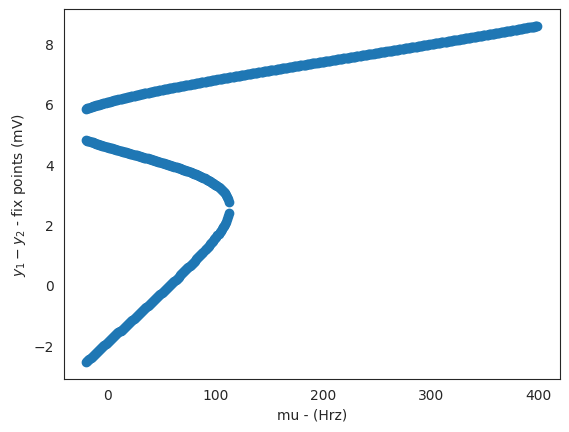

In [14]:
A = 3.25
B = 22
C = 135
c1 = 1*C
c2 = 0.8*C  #0.8
c3 = 0.25*C
c4 = 0.25*C
v0 = 6         # mV
a = 100        # s^-1
b = 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1
divA = (A/a)
divB = (B/b)
mu_all = np.arange(-20,400,1)
y = np.random.rand(len(mu_all))

final_res = []
for mu in mu_all:
  x = np.arange(-4,100,0.0001)
  y1 = x
  y2 = (divA*mu) + (divA*c2*sigm(nu_max, v0,  r, divA*c1*sigm(nu_max, v0,  r, x))) - (divB*c4*sigm(nu_max, v0,  r, divA*c3*sigm(nu_max, v0,  r, x)))
  idx = np.argwhere(np.diff(np.sign(y1 - y2))).flatten()
  final_res.append(idx)

new_values = []
for i in range(0,len(final_res)):
  new_values.append(y1[final_res[i]])

w = [[mu_all[i]] * len(new_values[i]) for i in range(len(new_values))]

x_to_plot = [item for sublist in w for item in sublist]
y_to_plot = [item for sublist in new_values for item in sublist]
plt.scatter(x_to_plot, y_to_plot)
plt.xlabel('mu - (Hrz)')
plt.ylabel('$y_{1} - y_{2}$ - fix points (mV)')

Now that we have the fixed points, we continue the local linear stability analysis by linearzing the dynamics around the fixed points and calculating the Jacobian matrix to study the behavior of the system around the fixed points (thus the name local stability analysis). This is achieved by looking at the eigenvalues of the Jacobian matrix. A fixed point is said to be stable if all the eigenvalues have a negative real part, and unstable if some of the eigenvalues have a positive real part.  

In a nutshell:
- a fix point is STABLE if the first eigenvalues real part < 0
- a fix point is UNSTABLE if the first eigenval real part > 0
- a fix point is critical if one of the eigenval real part = 0 (or close)


NOTE: if the first eigenvalue has an immaginary part the system is oscillating



Text(0, 0.5, '$y_{1} - y_{2}$ - fix points (mV)')

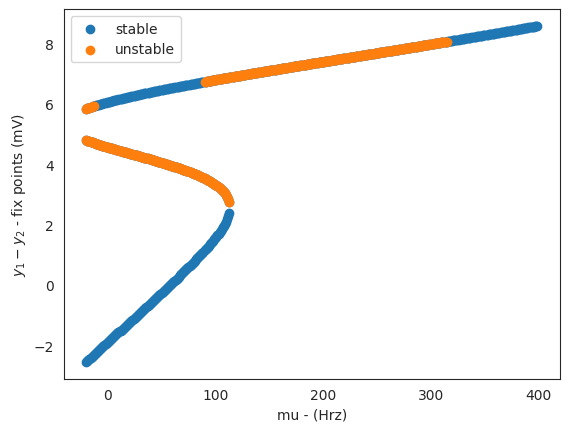

In [15]:
def differentiate_sigmoid(nu_max, v0,  r, x):
  ds_dx = (r*2*nu_max*(np.exp(r*(v0-x)))) / (1+np.exp(r*(v0-x)))**2
  return ds_dx

un = 0
stability = []
for j in range(0,len(new_values)):
    for me in range(0,len(new_values[j])):
      J = np.zeros((6, 6))
      fix_point = new_values[j][me]
      first_coordinate = (A/a)*sigm(nu_max,v0,r,fix_point)
      J[0, 3] = 1
      J[1, 4] = 1
      J[2, 5] = 1
      J[3, 0] = -a**2
      J[3,1] = A*a*differentiate_sigmoid(nu_max,v0,r,fix_point)
      J[3,2] = -A*a*differentiate_sigmoid(nu_max,v0,r,fix_point)
      J[3,3] = -2*a
      J[4, 0] = (A*a*c2*c1)*differentiate_sigmoid(nu_max,v0,r,c1*first_coordinate)
      J[4, 1] = -a**2
      #J[4, 3] = -2*a
      J[4, 4] = -2*a
      J[5, 0] = (b*B*c4*c3)*differentiate_sigmoid(nu_max,v0,r,c3*first_coordinate)
      J[5, 2] = -b**2
      J[5, 5] = -2*b
      evals = np.linalg.eigvals(J)
      evals
      stability_per = np.zeros(len(evals))
      for i in range(0,len(evals)):
        real_part = np.real(evals[i])
        if real_part > 0:
          un = 1
          stability_per[i] =un
        else:
          un = 0
          stability_per[i] = un
      value = np.zeros(len(new_values[j]))
      if stability_per.any()==1:
        value = 1
      else:
        value = 0
      stability.append(value)

w = [[mu_all[i]] * len(new_values[i]) for i in range(len(new_values))]
index_unstable = np.where(np.array(stability)==1)

x_to_plot = [item for sublist in w for item in sublist]
y_to_plot = [item for sublist in new_values for item in sublist]
x_array = np.array(x_to_plot)
y_array = np.array(y_to_plot)
x_array[index_unstable]
plt.scatter(x_to_plot, y_to_plot, label='stable')
plt.scatter(x_array[index_unstable], y_array[index_unstable], label='unstable')
plt.legend()
plt.xlabel('mu - (Hrz)')
plt.ylabel('$y_{1} - y_{2}$ - fix points (mV)')

Every time the system changes stability, we have a transition point where the Jacobian matrix has eigenvalues with zero real part. After having a closer look at the eigenvalues of those transition points, further information can be gathered. In this case, on the upper unstable section (between 90 and 315 approx). at the transition points, the fixed point has two complex conjugate eigenvalues which cross the imaginary axis (first towards positive real part around 90 and then towards negative real parts around 315). This corresponds to what is called two Hopf bifurcation within which the system exhibits oscillatory behavior. For lower values of p, the system is bistable with three fixed points, and depending on the initial conditions, will tend to reach one of the stable fixed points (Further information and analaysis can be found at: https://pubmed.ncbi.nlm.nih.gov/17052158/)

These fixed points can now be added to the phase-plane plots seen previously:


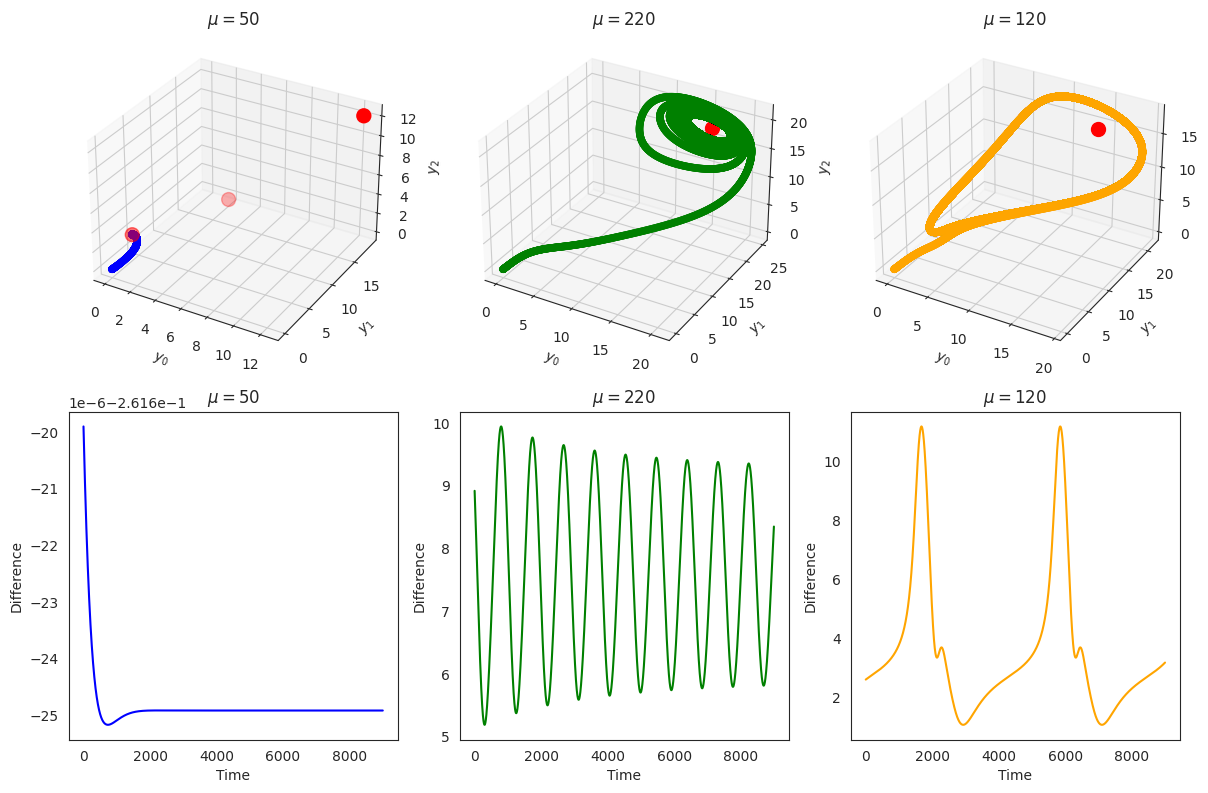

In [16]:
# Parameter settings
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = 0.25*C
C4 = 0.25*C
v0 = 6         # mV
tau_e = 10
tau_i = 20
a = (1/tau_e)*1000 # 100        # s^-1
b = (1/tau_i)*1000 # 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1

# Simulation setting
start = 0.0
stim_time =10
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)

# For simplicity, we set p as a constant
mu = [50, 220, 120]

# Output Initialization
y = np.zeros((6,vec_len))
res_y0 = []
res_y1 = []
res_y2 = []
y0coord = np.zeros((len(mu), 3))
y1coord = np.zeros((len(mu), 3))
y2coord = np.zeros((len(mu), 3))

# Euler integration method to solve JR differential equations
for j in range(0,len(mu)):
  for i in range (1,vec_len):
    y[0,i] = y[0,i-1] + y[3,i-1]*dt
    y[1,i] = y[1,i-1] + y[4,i-1]*dt
    y[2,i] = y[2,i-1] + y[5,i-1]*dt
    y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
    y[4,i] = y[4,i-1] + dt * (A*a*(mu[j] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
    y[5,i] = y[5,i-1] + dt * (B*b*(C4*sigm(nu_max,v0,r,(C3*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))
  res_y0.append(y[0,:].copy())
  res_y1.append(y[1,:].copy())
  res_y2.append(y[2,:].copy())

  value = mu[j]
  indices = [index for index, element in enumerate(x_to_plot) if element == value]
  for h in range(0,len(y_array[indices])):
    y0coord[j,h] = (A/a)*sigm(nu_max,v0,r,y_array[indices[h]])
    y1coord[j,h] = (A/a)*(mu[j]+ C2*sigm(nu_max,v0,r,C1*y0coord[j,h]))
    y2coord[j,h] = (B/b)*(C4*sigm(nu_max,v0,r,C3*y0coord[j,h]))


# Create the figure and subplots using GridSpec
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 3, figure=fig)

# First row of subplots
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax1.scatter(C * res_y0[0], res_y1[0], res_y2[0], marker='o', color='blue')
ax1.scatter(C * y0coord[0, :], y1coord[0, :], y2coord[0, :], c='red', marker='o', s=100)
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('$y_1$')
ax1.set_zlabel('$y_2$')
ax1.set_title('$\mu=50$')

ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax2.scatter(C * res_y0[1], res_y1[1], res_y2[1], marker='o', color='green')
ax2.scatter(C * y0coord[1, 0], y1coord[1, 0], y2coord[1, 0], c='red', marker='o', s=100)
ax2.set_xlabel('$y_0$')
ax2.set_ylabel('$y_1$')
ax2.set_zlabel('$y_2$')
ax2.set_title('$\mu=220$')

ax3 = fig.add_subplot(gs[0, 2], projection='3d')
ax3.scatter(C * res_y0[2], res_y1[2], res_y2[2], marker='o', color='orange')
ax3.scatter(C * y0coord[2, 0], y1coord[2, 0], y2coord[2, 0], c='red', marker='o', s=100)
ax3.set_xlabel('$y_0$')
ax3.set_ylabel('$y_1$')
ax3.set_zlabel('$y_2$')
ax3.set_title('$\mu=120$')

# Second row of subplots
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(res_y1[0][4000:13000] - res_y2[0][4000:13000], color='blue')
ax4.set_xlabel('Time')
ax4.set_ylabel('Difference')
ax4.set_title('$\mu=50$')

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(res_y1[1][4000:13000] - res_y2[1][4000:13000], color='green')
ax5.set_xlabel('Time')
ax5.set_ylabel('Difference')
ax5.set_title('$\mu=220$')

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(res_y1[2][4000:13000] - res_y2[2][4000:13000], color='orange')
ax6.set_xlabel('Time')
ax6.set_ylabel('Difference')
ax6.set_title('$\mu=120$')

plt.tight_layout()
plt.show()


## Network model of whole-brain anatomical connectivity

Having gained an understanding of single node modeling and its impact on system dynamics with different parameter configurations, we can now expand our analysis to the whole-brain level at a macro-scale. We will divide the brain into sub-regions and apply the Jansen and Ritt Model to each region. The connectivity between each node will be modeled using structural connectome data derived from Diffusion Weighted Imaging data.<br/>
<br/>
***Parcellation*** <br/>
For this tutorial we’ll be using the Schaefer et al. 2018. This atlas was generated from fMRI data from 1000 healthy control participants. Speicifically we will be using the 200 parcels and 7 Network version of this atlas.

![alt text](https://pbs.twimg.com/media/Dz2u7WCU8AIxNJ4?format=jpg&name=large)


To retrieve the Schaefer atlas we’ll use the `fetch_atlas_*` family of functions provided for by nilearn.datasets and download it into a local directory

In [17]:
!mkdir rois
parcel_dir = './rois/'
atlas_schaefer_2018 = datasets.fetch_atlas_schaefer_2018(n_rois=200,
                                                         yeo_networks=7,
                                                         resolution_mm=2,
                                                         data_dir=parcel_dir)



Dataset created in ./rois/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


The map key in `atlas_schaefer_2018` is a `.nii.gz` image which contains a 3D NIFTI volume with a label for a given (x,y,z) voxel. Since these images are 3D volumes (sort of like structural images), we can view them using nilearn’s plotting utilities:



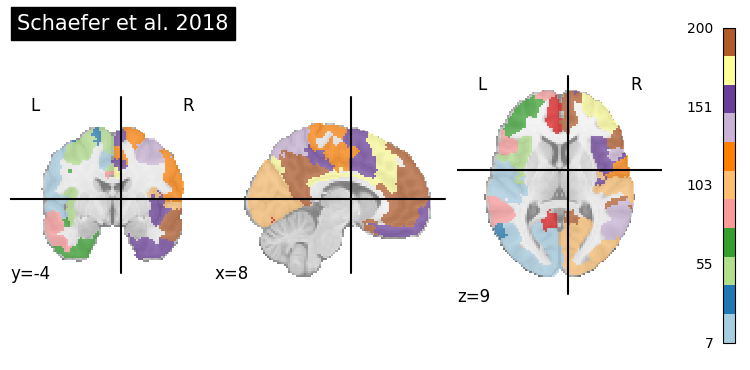

In [18]:
#Define where to slice the image
cut_coords = (8, -4, 9)
#Show a colorbar
colorbar=True
#Color scheme to show when viewing image
cmap='Paired'

#Plot the parcellation schema referred to by atlas_schaefer_2018
nplot.plot_roi(atlas_schaefer_2018['maps'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='Schaefer et al. 2018')

You’ll notice that the colour bar on the right shows the number of labels in each atlas and which colour corresponds to which network

The 7 Network parcellation includes the following networks:

1. Visual<br/>
2. Somatosensory<br/>
3. Dorsal Attention<br/>
4. Ventral Attention<br/>
5. Limbic<br/>
6. Frontoparietal<br/>
7. Default<br/>


The parcel areas labelled with 0 are background voxels not associated with a particular network.

Now that we have imported the atlas, in the next cell, we extract the label names and corresponding label coordinates in millimeters. The label names represent specific brain regions, while the label coordinates indicate their spatial locations.

The distance between two regions is calculated using the following formula:

\begin{equation}
\text{distance} = \sqrt{\sum_{i=1}^{n}(coords_{\text{{roi1}}}^i - coords_{\text{{roi2}}}^i)^2}
\end{equation}


In this formula, $coords_{\text{{roi1}}}$ and $coords_{\text{{roi2}}}$ represent the coordinate vectors of the two regions of interest (ROI). By substituting the appropriate indices into the formula, the Euclidean distance between the corresponding coordinates is calculated.

In [19]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
  for roi2 in range(coords.shape[0]):
    distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
    distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




In [ ]:
type(distance)

numpy.ndarray

**Structural Connectivity**

As introduced before the connectivity between different nodes/parcels is modelled using the structural connectivity (SC) which scales the long-range connections between distant brain regions. Mathematically, together with the global scaling factor G, it is a factor of the long-range input onto a region.
In the simplest case, without time edelays, local connectivity and noise:
\begin{equation}
\dot{x}_i = N(x_{i}(t)) + G\sum_1^n SC_{ij} x_j
\end{equation}
Wherein $\dot{x}_i$ is the derivative of the date variable, $N(x_{i}(t))$ is the nerual mass model function, $G$ is the global scaling factor, $SC_{ij}$ is the connections strength between regions $i$ and $j$ and $x_j$ is the output from region $j$.

In the subsequent cell, we import the SC matrix for the average of the Human Connectome Project (HCP) dataset. Additionally, we compute the conduction delay between each pair of regions by dividing the distance matrix by the conduction velocity of 5 ms, which is based on previous studies.

Text(0.5, 1.0, 'Normalized Streamlines Count')

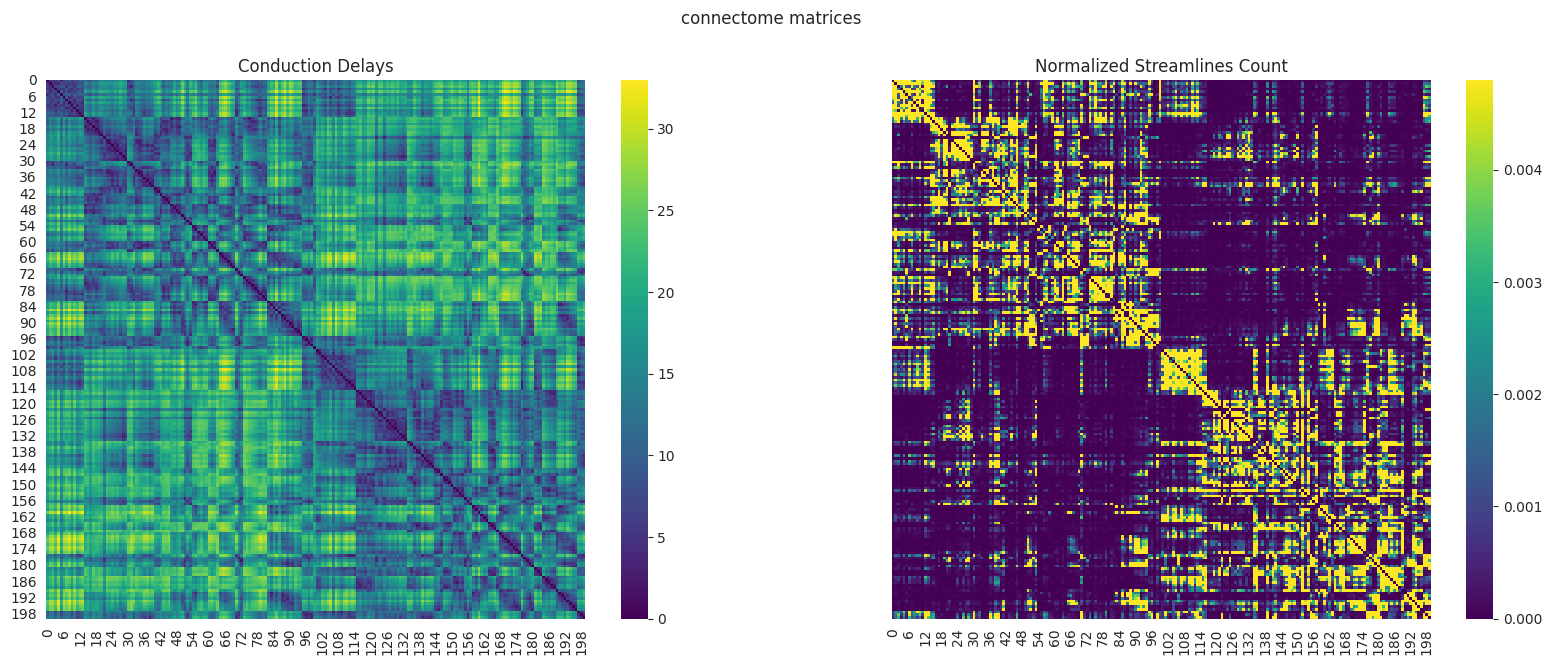

In [20]:
url = "https://raw.githubusercontent.com/GriffithsLab/PyTepFit/main/data/Schaefer2018_200Parcels_7Networks_count.csv"
count = NormalizeData(np.array(pd.read_csv(url,  header=None, sep=' ')))

delays = distance/conduction_velocity

fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
fig.suptitle('connectome matrices')

# distance
sns.heatmap(delays, cmap='viridis', ax=axes.flat[0], square=True)
axes.flat[0].set_title('Conduction Delays')
#axes.flat[0].set_xticklabels(label_stripped, rotation=90);
# axes.flat[0].set_yticklabels(label_stripped, rotation=0);

# wieghts (normalized between 0 and 3)
sns.heatmap(count, vmin=0.0, vmax=count.mean(), cmap='viridis', ax=axes.flat[1], square=True)
axes.flat[1].set_title('Normalized Streamlines Count')
# axes.flat[1].set_xticklabels(label_stripped, rotation=90)
# axes.flat[1].set_yticklabels(label_stripped, rotation=0)

This can also be plotted on a brain surface using  `nilearn.plotting.view_connectome` function

In [21]:
plotting.view_connectome(
    count, coords, edge_threshold="97%")

Output hidden; open in https://colab.research.google.com to view.

We have all the information necessary for setting up our SC matrix inside TVB

In [22]:
conn = connectivity.Connectivity()
conn.weights = count
conn.region_labels = np.array(label_stripped)
conn.delays = delays
conn.centres = coords
conn.tract_lengths = distance


Schaefer_parcel = nl.image.load_img(atlas_schaefer_2018['maps']).get_fdata().flatten()


areas=[]
for value in range(1,np.unique(Schaefer_parcel).shape[0]):
    areas.append(np.where(Schaefer_parcel==value)[0].shape[0])

areas= np.array(areas)
conn.areas = areas
conn.number_of_connections = np.count_nonzero(conn.weights)

conn.cortical = np.broadcast_to(True, (conn.weights.shape[0]))
conn.orientations = np.zeros((conn.centres.shape))

conn.configure()

conn

,value
Number of connections,27722
Number of regions,200
Undirected,True
areas,"[min, median, max] = [114, 627.5, 1446] dtype = float64 shape = (200,)"
tract_lengths,"[min, median, max] = [0, 81.5843, 164.973] dtype = float64 shape = (200, 200)"
tract_lengths (connections),"[min, median, max] = [7.48331, 74.4312, 160.761] dtype = float64 shape = (27722,)"
tract_lengths-non-zero,"[min, median, max] = [7.48331, 81.7557, 164.973] dtype = float64 shape = (39800,)"
weights,"[min, median, max] = [0, 0.000147667, 1] dtype = float64 shape = (200, 200)"
weights-non-zero,"[min, median, max] = [4.92223e-05, 0.000492223, 1] dtype = float64 shape = (27722,)"


Now that we set up the connectivity we are ready for simulating the whole-brain activity using the Jansen and Rit model. So first we are going to define the function `simulate_resting_state` arguments:

- `simlength`: The duration of the simulation in milliseconds (default: 1000 ms).
- `tavg_per`: The temporal averaging period in milliseconds (default: 1 ms).
- `conn`: The connectivity matrix representing the structural connectivity of the neural network (default: None). If conn is not provided, the function assumes that you have a connectivity file or use load_default=True to load a default connectivity matrix.
- `sigma`: The noise levels in the model (default: None).
- `jrm_params`: Parameters for the Jansen-Rit neural mass model (default: None).
- `cpl_params`: Parameters for the coupling between neural masses (default: None).
- `int_dt`: The integration time step in milliseconds (default: 0.5 ms).
- `speed`: The conduction speed in mm/ms (default: 3 mm/ms).


The Jansen-Rit model is instantiated with the given parameters (`jrm_params`), or default parameters if `jrm_params` is None.
The variables of interest in the Jansen-Rit model are set to ('y0', 'y1', 'y2', 'y3', 'y4', 'y5') for monitoring purposes.
The noise levels (sigma) are set to default values if not provided.
The sigmoidal coupling model (`SigmoidalJansenRit`) is instantiated with the given parameters (`cpl_params`), or default parameters if `cpl_params` is None.
Integration Scheme:

The HeunStochastic integrator is used with the given integration time step (`int_dt`) and noise levels (`sigma`).
Initial Conditions and Monitors:

The initial conditions for the simulation are set to zeros, as stochastic integration is used.
A TemporalAverage monitor is created with the specified temporal averaging period (`tavg_per`).
Simulator Configuration and Execution:

The simulator is configured with the Jansen-Rit model, connectivity, coupling, integrator, initial conditions, simulation length, and monitor(s).
The simulation is executed using the run() method of the simulator object.
The temporal average data from the monitor is obtained.

In [23]:
def simulate_resting_state(simlength=1000., tavg_per=1, conn=None, sigma=None, jrm_params=None, cpl_params=None, int_dt=0.5, speed=3.):
    # Define the connectivity
    if conn is None:
        conn = connectivity.Connectivity.from_file()  # Assuming you have a connectivity file or use load_default=True
        conn.speed = np.array([speed])
        conn.configure()

    # Define the model
    if jrm_params is None:
        jrm_params = dict(v0=np.array([6.]))
    else:
        jrm_params = {k: np.array([v]) for k, v in jrm_params.items()}
    jrm = models.JansenRit(**jrm_params)
    jrm.variables_of_interest = ('y0', 'y1', 'y2', 'y3', 'y4', 'y5')
    jrm.stvar = np.array([0, 1, 2, 3, 4, 5])

    # Set the noise
    if sigma is None:
        phi_n_scaling = (jrm.a * jrm.A * (jrm.p_max - jrm.p_min) * 0.5) ** 2 / 2.
        sigma = np.zeros(6)
        sigma[3] = phi_n_scaling * 1e-5  # Shrink noise by 1e-5

    # Define the coupling
    if cpl_params is None:
        cpl_params = dict(a=np.array(0.00045))
    else:
        cpl_params = {k: np.array([v]) for k, v in cpl_params.items()}
    cpl = coupling.SigmoidalJansenRit(**cpl_params)

    # Set up the integration scheme
    solver = integrators.HeunStochastic(dt=int_dt, noise=noise.Additive(nsig=sigma))

    # Define initial conditions
    init_conds = np.zeros([100, 6, conn.weights.shape[0], 1])  # All zeros; doesn't matter as we are using stochastic integration

    # Define the monitor for temporal averaging
    tavg_mon = monitors.TemporalAverage()
    tavg_mon.period = tavg_per

    # Create the simulator object
    sim = simulator.Simulator(
        model=jrm,
        connectivity=conn,
        coupling=cpl,
        integrator=solver,
        initial_conditions=init_conds,
        simulation_length=simlength,
        monitors=(tavg_mon,),
    ).configure()

    # Run the simulation and obtain the temporal average data
    tavg_data = sim.run()

    # Return the temporal average data
    return tavg_data


Let's run the model!!!!

In [24]:
from tvb.simulator import noise

res = simulate_resting_state(simlength=5000, conn=conn,  sigma=None, jrm_params=None,
                             cpl_params=None, int_dt=0.5, speed=3.)


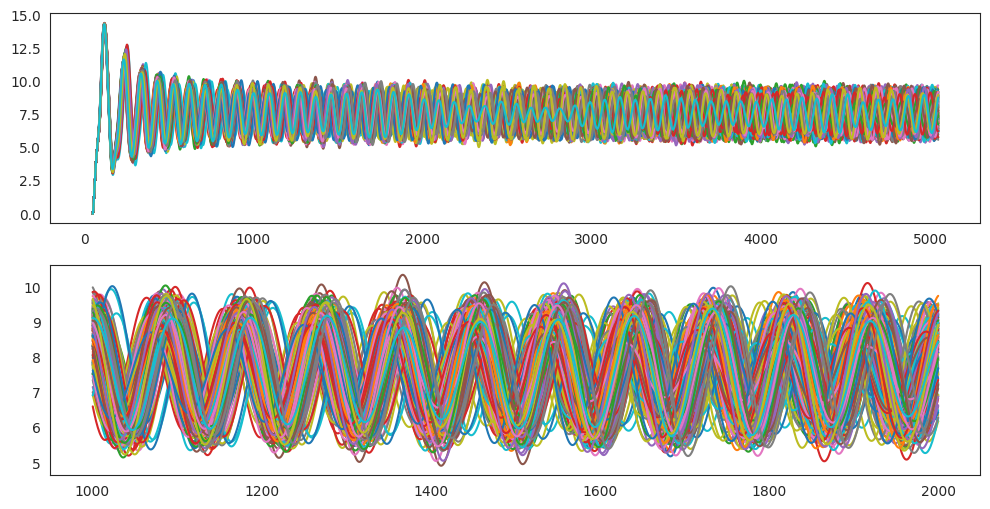

In [25]:
df_cPN = pd.DataFrame(np.squeeze(res[0][1][:,0,:]),index=res[0][0])
df_cPN.index.names = ['t']
df_cPN.columns.names = ['region']
df_cPN.columns = [label_stripped]

df_cEIN = pd.DataFrame(np.squeeze(res[0][1][:,1,:]),index=res[0][0])
df_cEIN.index.names = ['t']
df_cEIN.columns.names = ['region']
df_cEIN.columns = [label_stripped]

df_cIIN = pd.DataFrame(np.squeeze(res[0][1][:,2,:]),index=res[0][0])
df_cIIN.index.names = ['t']
df_cIIN.columns.names = ['region']
df_cIIN.columns = [label_stripped]

df_vPN = pd.DataFrame(np.squeeze(res[0][1][:,3,:]),index=res[0][0])
df_vPN.index.names = ['t']
df_vPN.columns.names = ['region']
df_vPN.columns = [label_stripped]

df_vEIN = pd.DataFrame(np.squeeze(res[0][1][:,4,:]),index=res[0][0])
df_vEIN.index.names = ['t']
df_vEIN.columns.names = ['region']
df_vEIN.columns = [label_stripped]

df_vIIN = pd.DataFrame(np.squeeze(res[0][1][:,5,:]),index=res[0][0])
df_vIIN.index.names = ['t']
df_vIIN.columns.names = ['region']
df_vIIN.columns = [label_stripped]


%matplotlib inline


df = df_cEIN - df_cIIN

df.index = np.round(df.index,1)

fig, ax = plt.subplots(nrows=2, figsize=(12,6))

fig = ax[0].plot(df)
fig = ax[1].plot(df[1000:2000])

Now that we have simulated EEG activity at the level of the parcels we are going to move back to the EEG space and for this we need the leadfield matrix

**Leadfield**

The leadfiled matrix is used to project local field potentials from region level (inside the brain) to the scalp surface for the calculation of EEG signals.

$$M = GX + E$$

where $M \in \mathbb{R}^{C \times T}$ is the sensor data, $G \in \mathbb{R}^{C \times S}$ is the lead-field (or gain) matrix, $X \in \mathbb{R}^{S \times T}$ is the source time course (stc) and $E \in \mathbb{R}^{C \times T}$ is additive Gaussian noise with zero mean and identity covariance


Here, we use pre-calculated matrix.

In the next cell we will move back to EEG space by performing a matrix multiplication between the leadfield matrix (leadfield) and the output of our resting-state simulation.

Not setting metadata
2 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Projections have already been applied. Setting proj attribute to True.


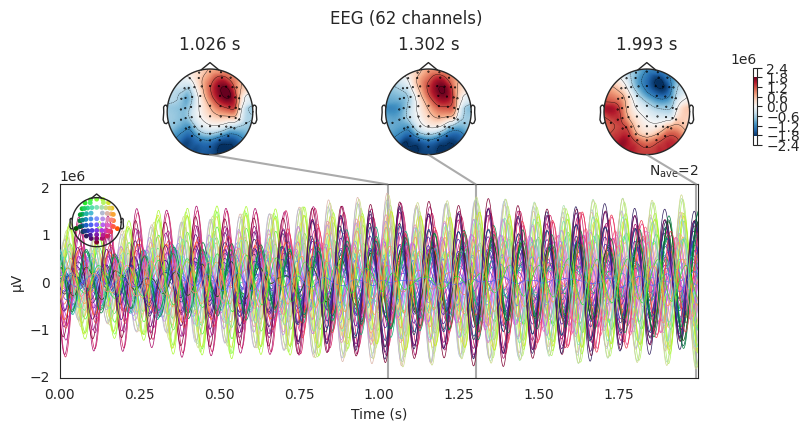

In [26]:
leadfield = np.load('/content/Data/leadfield', allow_pickle=True)

epoched = mne.read_epochs('/content/Data/all_avg.mat_avg_high_epoched', verbose=False)

dataeeg = np.vstack([(np.array(leadfield @ df[2000:4000].T)/1000), (np.array(leadfield @ df[2000:4000].T)/1000)]).reshape(2,62,2000)

for xx in range(dataeeg.shape[0]):
  for ch in range(dataeeg.shape[1]):
    dataeeg[xx,ch] = dataeeg[xx,ch] - dataeeg[xx,ch].mean()

evokeds=mne.EpochsArray(dataeeg,epoched.info,tmin=0)

evoked = evokeds.average()

evoked.plot_joint();

The next code snippet performs a Multitaper Power Spectral Density (PSD) analysis on EEG data. The PSD analysis helps us understand the distribution of power across different frequency bands in the EEG signal. The code utilizes the [MNE-Python](https://mne.tools/stable/index.html) library, specifically the  `compute_psd()` function.

    Using multitaper spectrum estimation with 7 DPSS windows


[Text(0.5, 1.0, 'Multitaper PSD (eeg)'),
 Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (dB)')]

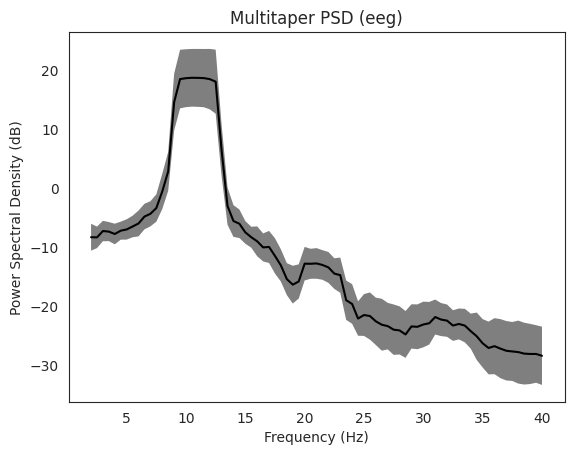

In [27]:
_, ax = plt.subplots()
spectrum = evokeds.compute_psd(fmin=2.0, fmax=40.0, tmax=3.0, n_jobs=None)
# average across epochs first
mean_spectrum = spectrum.average()
psds, freqs = mean_spectrum.get_data(return_freqs=True)
# then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)

ax.plot(freqs, psds_mean, color="k")
ax.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
ax.set(
    title="Multitaper PSD (eeg)",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)

Finally, in the next cell we utilize MNE-Python's `tfr_morlet()` function to compute time-frequency power and inter-trial coherence using Morlet wavelets and plot the spectrum for channel O1

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied


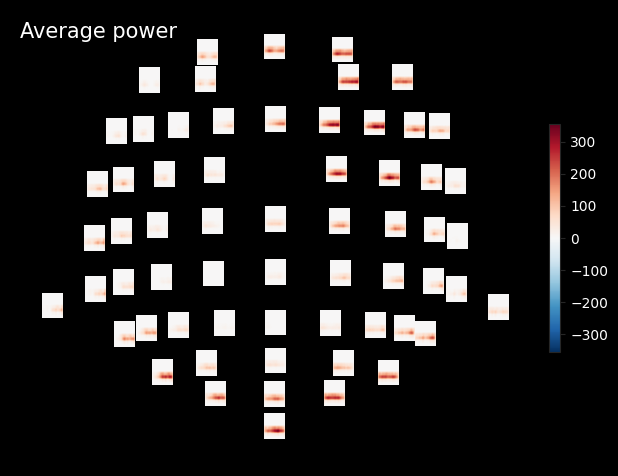

No baseline correction applied


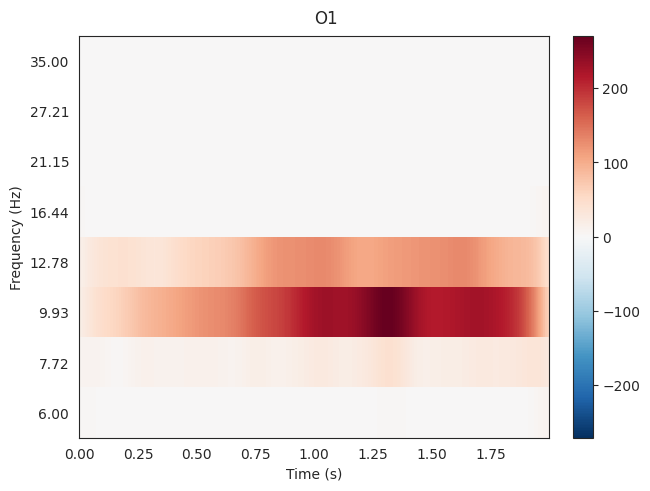

No baseline correction applied


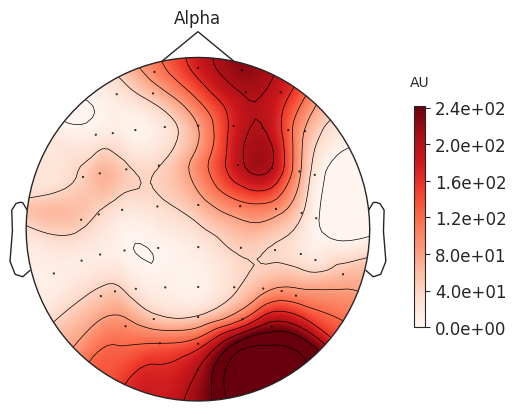

In [28]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    evokeds,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)


power.plot_topo( mode="logratio", title="Average power")
power.plot([evokeds.ch_names.index('O1')],
           baseline=None, mode="logratio",
           title=power.ch_names[epoched.ch_names.index('O1')])

fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)

topomap_kw = dict(
    ch_type="eeg", tmin=epoched.times[0], tmax=epoched.times[-1], baseline=None, mode="logratio", show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))

# Plot the Alpha topomap
power.plot_topomap(**plot_dict["Alpha"], axes=ax, **topomap_kw)
ax.set_title("Alpha")

plt.show()

If the model we use for the nodes remains constant, with identical parameters, the alpha oscillations observed in specific brain regions can solely arise from the structural connectivity between those regions.

Let's explore this further by modifying the connectome and see how this changing will affect the alpha oscillations

In [29]:
Vis = [index for index, word in enumerate(list(conn.region_labels)) if 'Vis' in word]
backup = conn.weights.copy()

conn.weights[Vis,:] = -100
conn.weights[:,Vis] = -100


Not setting metadata
2 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Projections have already been applied. Setting proj attribute to True.


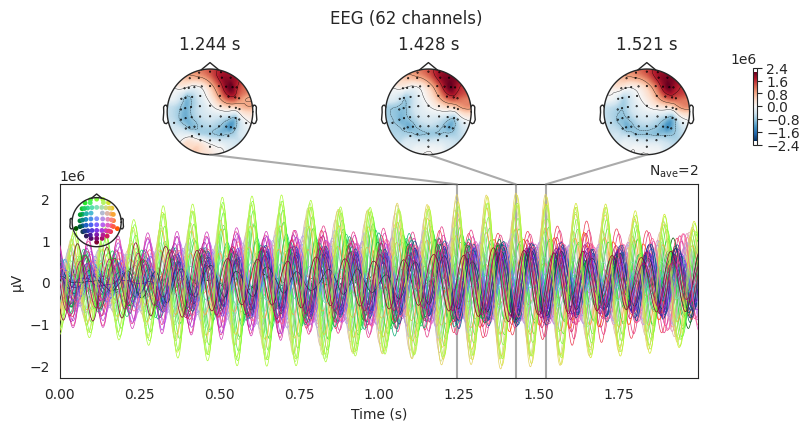

In [30]:
from tvb.simulator import noise

res = simulate_resting_state(simlength=5000, conn=conn,  sigma=None, jrm_params=None,
                             cpl_params=None, int_dt=0.5, speed=3.)


df_cPN = pd.DataFrame(np.squeeze(res[0][1][:,0,:]),index=res[0][0])
df_cPN.index.names = ['t']
df_cPN.columns.names = ['region']
df_cPN.columns = [label_stripped]

df_cEIN = pd.DataFrame(np.squeeze(res[0][1][:,1,:]),index=res[0][0])
df_cEIN.index.names = ['t']
df_cEIN.columns.names = ['region']
df_cEIN.columns = [label_stripped]

df_cIIN = pd.DataFrame(np.squeeze(res[0][1][:,2,:]),index=res[0][0])
df_cIIN.index.names = ['t']
df_cIIN.columns.names = ['region']
df_cIIN.columns = [label_stripped]

df_vPN = pd.DataFrame(np.squeeze(res[0][1][:,3,:]),index=res[0][0])
df_vPN.index.names = ['t']
df_vPN.columns.names = ['region']
df_vPN.columns = [label_stripped]

df_vEIN = pd.DataFrame(np.squeeze(res[0][1][:,4,:]),index=res[0][0])
df_vEIN.index.names = ['t']
df_vEIN.columns.names = ['region']
df_vEIN.columns = [label_stripped]

df_vIIN = pd.DataFrame(np.squeeze(res[0][1][:,5,:]),index=res[0][0])
df_vIIN.index.names = ['t']
df_vIIN.columns.names = ['region']
df_vIIN.columns = [label_stripped]


%matplotlib inline


df = df_cEIN - df_cIIN

df.index = np.round(df.index,1)



leadfield = np.load('/content/Data/leadfield', allow_pickle=True)

epoched = mne.read_epochs('/content/Data/all_avg.mat_avg_high_epoched', verbose=False)

dataeeg = np.vstack([(np.array(leadfield @ df[2000:4000].T)/1000), (np.array(leadfield @ df[2000:4000].T)/1000)]).reshape(2,62,2000)

for xx in range(dataeeg.shape[0]):
  for ch in range(dataeeg.shape[1]):
    dataeeg[xx,ch] = dataeeg[xx,ch] - dataeeg[xx,ch].mean()

evokeds=mne.EpochsArray(dataeeg,epoched.info,tmin=0)

evoked = evokeds.average()

evoked.plot_joint();


# @title Run the model with lesioned connectome

No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


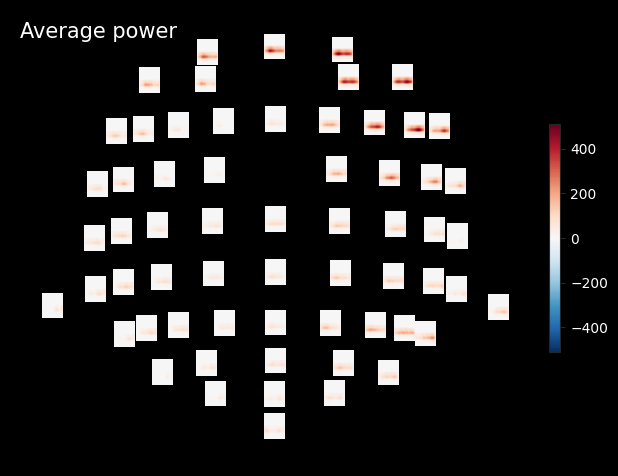

No baseline correction applied


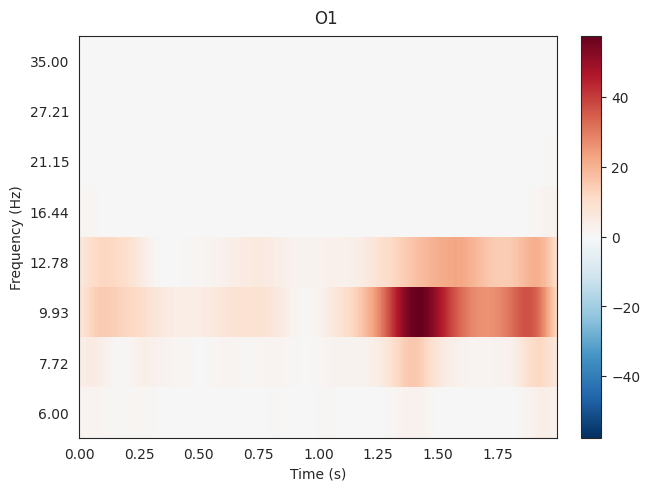

No baseline correction applied


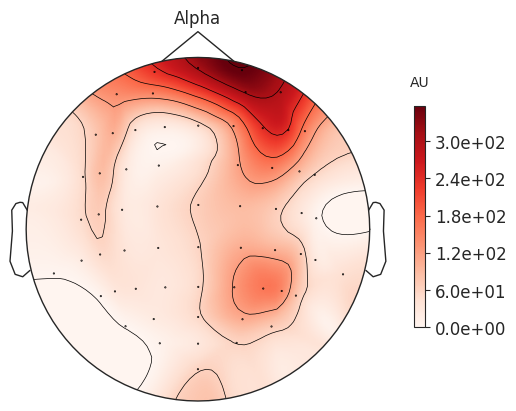

In [31]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    evokeds,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)


power.plot_topo( mode="logratio", title="Average power")
power.plot([evokeds.ch_names.index('O1')],
           baseline=None, mode="logratio",
           title=power.ch_names[epoched.ch_names.index('O1')])

fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)

topomap_kw = dict(
    ch_type="eeg", tmin=epoched.times[0], tmax=epoched.times[-1], baseline=None, mode="logratio", show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))

# Plot the Alpha topomap
power.plot_topomap(**plot_dict["Alpha"], axes=ax, **topomap_kw)
ax.set_title("Alpha")

plt.show()

**Modelling Brain Stimulation**

In [32]:
SomMot = [index for index, word in enumerate(list(conn.region_labels)) if 'SomMot' in word]

stim_weights = np.zeros((conn.region_labels.shape[0]))
stim_weights[SomMot[10:16]] = 5. #inject stimulus to left hemi

plotting.view_markers(coords[np.where(stim_weights>0)[0]])

Output hidden; open in https://colab.research.google.com to view.

In [33]:
def run_stimulus_evoked_activity(simlength = 1000.,tavg_per=1.,conn=None,sigma=None,
           jrm_params=None, cpl_params = None,int_dt=0.5,speed=3.,
           stim_eqn_params = dict(onset=1.5e3,T=500,tau=50), do_stim = False,stim_weighting=None):


    # Define the connectivity

    if conn is None:
        conn = connectivity.Connectivity.from_file()#(load_default=True)
        conn.speed = np.array([speed])
        conn.configure()
        w_orig = conn.weights.copy()
        w_norm = (w_orig.T / w_orig.sum(axis=1) ).T
        w_norm[np.isnan(w_norm)] = 0


    # Define the model

    if jrm_params is None:
        jrm_params = dict(v0=np.array([6.]))
    else:
        jrm_params = {k: np.array([v]) for k,v in jrm_params.items()}
    jrm = models.JansenRit(**jrm_params)
    jrm.variables_of_interest = ('y0', 'y1', 'y2', 'y3', 'y4', 'y5')
    jrm.stvar = np.array([0,1,2,3,4,5])

    # Set the noise

    if sigma is None:
        phi_n_scaling = (jrm.a * jrm.A * (jrm.p_max-jrm.p_min) * 0.5 )**2 / 2.
        sigma         = np.zeros(6)
        sigma[3]      = phi_n_scaling *1e-5 #shrank noise by 1e-5


    # Define a stimulus

    if do_stim == False:
        stimulus = None
    else:
        stim_eqn_t = equations.PulseTrain()
        for k,v in stim_eqn_params.items(): stim_eqn_t.parameters[k] = v
        stimulus = patterns.StimuliRegion(temporal=stim_eqn_t,
                                        connectivity=conn,
                                        weight=stim_weighting)

    stimulus.configure_time(np.arange(0., 3e3, 2**-4))


    # Define the coupling

    if cpl_params == None:
        cpl_params = dict(a=np.array(0.00045))
    else:
        cpl_params = {k: np.array([v]) for k,v in cpl_params.items()}
    cpl = coupling.Linear(**cpl_params)


    # Set up the integration scheme

    solver = integrators.HeunStochastic(dt=int_dt,noise=noise.Additive(nsig=sigma)) #integrator dt is bottleneck


    # Define initial conditions

    init_conds = np.zeros([100,6,200,1]) # all zeros; doesn't really matter as we are using stochastic integration
    #                                     dimensions are specific to jansen-rit model (namely 6 state variables)


    tavg_mon = monitors.TemporalAverage()
    tavg_mon.period = tavg_per

    mons=(tavg_mon,)






    # Create the simulator object

    sim = simulator.Simulator(
        model=jrm,
        connectivity=conn,
        coupling=cpl,
        integrator=solver,
        initial_conditions=init_conds,
        simulation_length=simlength,
        monitors=mons,
        stimulus=stimulus
    ).configure()



    # Run the sim and put results into dataframes

    tavg_data= sim.run()



    # Return a bunch of simulation outputs

    return tavg_data

In [34]:
node2use = np.where(stim_weights!=0)[0]

stim_weighting = np.zeros(conn.region_labels.shape[0])

# configure stimulus spatial pattern
stim_weight = stim_weights[np.where(stim_weights!=0)[0]]
stim_weighting[np.where(stim_weights!=0)[0]] = stim_weight



jrm_params = dict(v0=6.,a_1=1,a_2=0.8,a_3=0.2,a_4=0.25)


res = run_stimulus_evoked_activity(simlength = 5000.,tavg_per=1.,conn=conn,sigma=np.zeros(6),
                                   jrm_params=jrm_params, cpl_params = dict(a=np.array(0.0000045)),int_dt=0.5,speed=3.,
                                   stim_eqn_params = dict(onset=1250,T=1500,tau=50), do_stim = True ,stim_weighting=stim_weighting)

(1.0, 1.1)

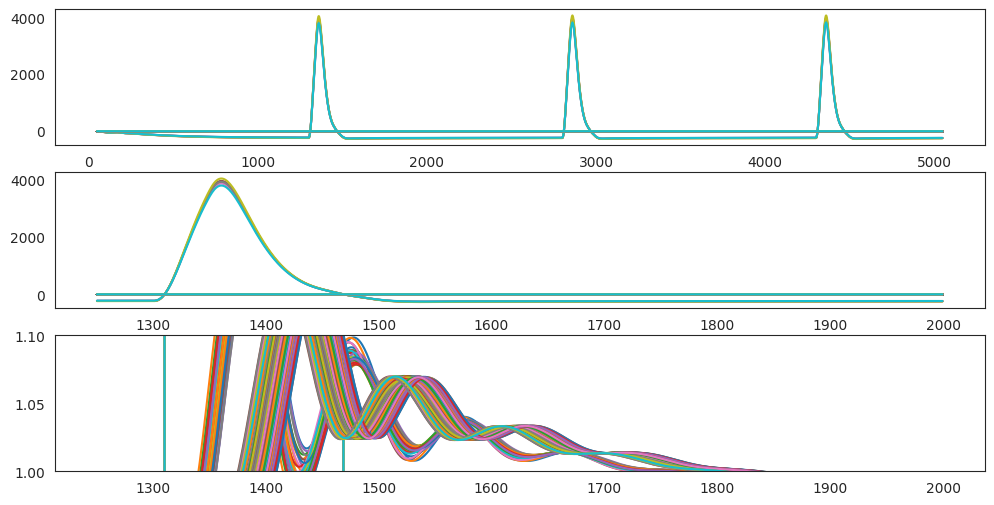

In [35]:
df_cPN = pd.DataFrame(np.squeeze(res[0][1][:,0,:]),index=res[0][0])
df_cPN.index.names = ['t']
df_cPN.columns.names = ['region']


df_cEIN = pd.DataFrame(np.squeeze(res[0][1][:,1,:]),index=res[0][0])
df_cEIN.index.names = ['t']
df_cEIN.columns.names = ['region']


df_cIIN = pd.DataFrame(np.squeeze(res[0][1][:,2,:]),index=res[0][0])
df_cIIN.index.names = ['t']
df_cIIN.columns.names = ['region']


df_vPN = pd.DataFrame(np.squeeze(res[0][1][:,3,:]),index=res[0][0])
df_vPN.index.names = ['t']
df_vPN.columns.names = ['region']


df_vEIN = pd.DataFrame(np.squeeze(res[0][1][:,4,:]),index=res[0][0])
df_vEIN.index.names = ['t']
df_vEIN.columns.names = ['region']

df_vIIN = pd.DataFrame(np.squeeze(res[0][1][:,5,:]),index=res[0][0])
df_vIIN.index.names = ['t']
df_vIIN.columns.names = ['region']


df = df_cEIN - df_cIIN

df_norm = df / df.loc[1250:].mean(axis=0)
df_norm.index = np.round(df_norm.index,1)

fig, ax = plt.subplots(nrows=3, figsize=(12,6))

fig = ax[0].plot(df_norm)
fig = ax[1].plot(df_norm[1250:2000])
fig= ax[2].plot(df_norm[1250:2000])
ax[2].set_ylim((1,1.1))

Projections have already been applied. Setting proj attribute to True.


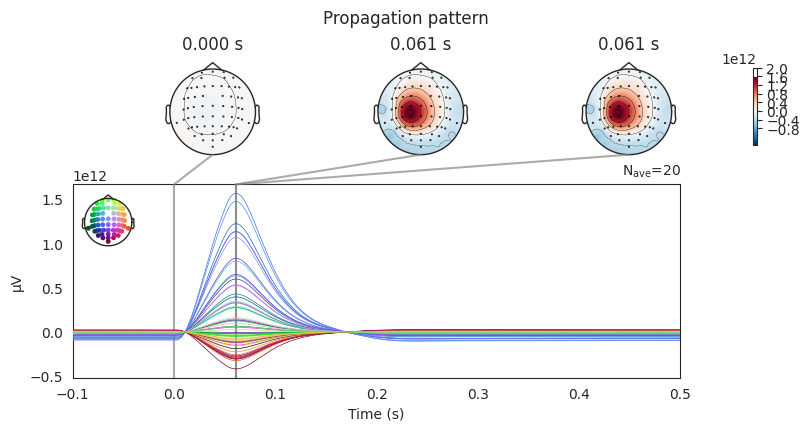

In [ ]:
source_eeg = np.array(df_norm)[250:2250,:].T
cutted_EEG = leadfield @ source_eeg


leadfield = np.load('/content/Data/leadfield', allow_pickle=True)

epoched = mne.read_epochs('/content/Data/all_avg.mat_avg_high_epoched', verbose=False)

for trial in range(epoched._data.shape[0]):
  epoched._data[trial,:,:] = cutted_EEG

evoked = epoched.average()


ts_args = dict(xlim=[-0.1,0.5])
ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=-0.005, tmax=0.004)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.008, tmax=0.1)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.030, tmax=0.1)
times = [peak_locs1, peak_locs2, peak_locs3]

evoked.plot_joint(ts_args=ts_args, times=times, title='Propagation pattern');

<Axes: xlabel='t', ylabel='region'>

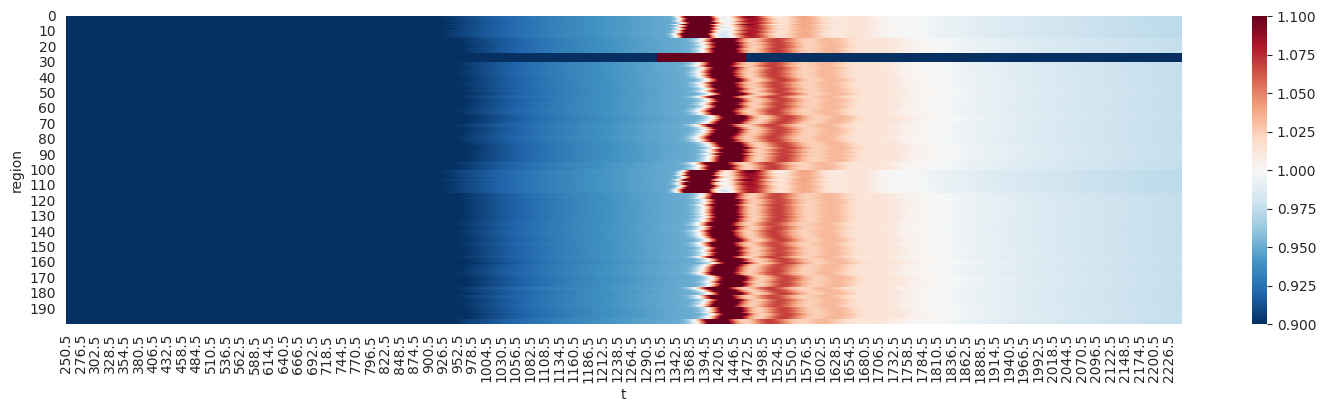

In [ ]:
fig, ax = plt.subplots(figsize=(18,4))
sns.heatmap(df_norm.loc[250:2250].T,cmap='RdBu_r',vmin=0.9,vmax=1.1, ax=ax)

Let's plot the simulatated activated on a surface

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import nibabel



# Standard scientific python import commands
import os,sys,glob,numpy as np,pandas as pd,seaborn as sns
sns.set_style('white')

%matplotlib inline
from matplotlib import pyplot as plt


# Some more matplotlib viz things
from matplotlib.pyplot import subplot
from matplotlib import cm
from numpy import exp,sin,cos,pi,tan,tanh
from matplotlib.tri import Triangulation
from IPython.display import Image,display,clear_output
from moviepy.editor import ImageSequenceClip

def __(num): return np.array([num])

from matplotlib import cm

def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):

  r"""Plot surfaces, surface patterns, and region patterns with matplotlib

  This is a general-use function for neuroimaging surface-based data, and
  does not necessarily require construction of or interaction with tvb
  datatypes.

  See also:  plot_surface_mpl_mv



  Parameters
  ----------

  vtx           : N vertices x 3 array of surface vertex xyz coordinates

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping
                  (N regions x 1 array), in which case the region mapping
                  bust also be given as an argument.

  rm            : region mapping - N vertices x 1 array with (up to) N
                  regions unique values; each element specifies which
                  region the corresponding surface vertex is mapped to

  reorient      : modify the vertex coordinate frame and/or orientation
                  so that the same default rotations can subsequently be
                  used for image views. The standard coordinate frame is
                  xyz; i.e. first,second,third axis = left-right,
                  front-back, and up-down, respectively. The standard
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.

                  Options:

                    tvb (default)   : swaps the first 2 axes and applies a rotation

                    fs              : for the standard freesurfer (RAS) orientation;
                                      e.g. fsaverage lh.orig.
                                      No transformations needed for this; so is
                                      gives same result as reorient=None

  view          : specify viewing angle.

                  This can be done in one of two ways: by specifying a string
                  corresponding to a standard viewing angle, or by providing
                  a tuple or list of tuples detailing exact rotations to apply
                  around each axis.

                  Standard view options are:

                  lh_lat / lh_med / rh_lat / rh_med /
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial
                   surfaces will not be visible, so e.g. 'rh_med' will look the
                   same as 'lh_lat')

                  Arbitrary rotations can be specied by a tuple or a list of
                  tuples, each with two elements, the first defining the axis
                  to rotate around [0,1,2], the second specifying the angle in
                  degrees. When a list is given the rotations are applied
                  sequentially in the order given.

                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees
                  rotation around the first axis, followed by 45 degrees rotate
                  around the second axis.

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below /
                  above these values

  nz_thr        : near-zero threshold - set to zero all datapoints with absolute
                  values smaller than this number. Default is a very small
                  number (1E-20), which unless your data has very small numbers,
                  will only mask out actual zeros.

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):

                    - 'shading'        (either 'gourand' or omit;
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual
                                       effect of this will depend on both the
                                       surface density and the figure size
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity

  ax            : figure axis

  figsize       : figure size (ignore if ax provided)

  title         : text string to place above figure




  Usage
  -----


  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})


  """

  # Copy things to make sure we don't modify things
  # in the namespace inadvertently.

  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle

  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order
    # yxz for some reason. So first change that:
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()

    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)



  # ...get rotations for standard view options

  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view

  # (rh_lat is the default 'view' argument because no rotations are
  #  for that one; so if no view is specified when the function is called,
  #  the 'rh_lat' option is chose here and the surface is shown 'as is'


  # ...apply rotations

  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)



  # 2. Sort out the data


  # ...if no data is given, plot a vector of 1s.
  #    if using region data, create corresponding surface vector
  if data is None:
    data = np.ones(vtx.shape[0])
  elif data.shape[0] != vtx.shape[0]:
    data = np.array([data[r] for r in rm])

  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)


  # 3. Create the surface triangulation object

  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])

  # 4. Make the figure

  if ax is None: fig, ax = plt.subplots(figsize=figsize)

  #if shade = 'gouraud': shade_opts['shade'] =
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)

  ax.set_aspect('equal')
  ax.axis('off')

  if title is not None: ax.set_title(title)






def plot_surface_mpl_mv(vtx=None,tri=None,data=None,rm=None,hemi=None,   # Option 1
                        vtx_lh=None,tri_lh=None,data_lh=None,rm_lh=None, # Option 2
                        vtx_rh=None,tri_rh=None,data_rh=None,rm_rh=None,
                        title=None,**kwargs):

  r"""Convenience wrapper on plot_surface_mpl for multiple views

  This function calls plot_surface_mpl five times to give a complete
  picture of a surface- or region-based spatial pattern.

  As with plot_surface_mpl, this function is written so as to be
  generally usable with neuroimaging surface-based data, and does not
  require construction of of interaction with tvb datatype objects.

  In order for the medial surfaces to be displayed properly, it is
  necessary to separate the left and right hemispheres. This can be
  done in one of two ways:

  1. Provide single arrays for vertices, faces, data, and
     region mappings, and addition provide arrays of indices for
     each of these (vtx_inds,tr_inds,rm_inds) with 0/False
     indicating left hemisphere vertices/faces/regions, and 1/True
     indicating right hemisphere.

     Note: this requires that

  2. Provide separate vertices,faces,data,and region mappings for
     each hemisphere (vtx_lh,tri_lh; vtx_rh,tri_rh,etc...)



  Parameters
  ----------

  (see also plot_surface_mpl parameters info for more details)

  (Option 1)

  vtx               :  surface vertices

  tri               : surface faces

  data              : spatial pattern to plot

  rm                : surface vertex to region mapping

  hemi              : hemisphere labels for each vertex
                      (1/True = right, 0/False = left) -


  OR

  (Option 2)

  vtx_lh            : left hemisphere surface_vertices
  vtx_rh            : right ``      ``    ``     ``

  tri_lh            : left hemisphere surface faces
  tri_rh            : right ``      ``    ``     ``

  data_lh          : left hemisphere surface_vertices
  data_rh          : right ``      ``    ``     ``

  rm_lh            : left hemisphere region_mapping
  rm_rh            : right ``      ``    ``     ``


  title            : title to show above middle plot

  kwargs           : additional tripcolor kwargs; see plot_surface_mpl



  Examples
  ----------

  # TVB default data

  # Plot one column of the region-based tract lengths
  # connectivity matrix. The corresponding region is
  # right auditory cortex ('rA1')

  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                      hemi=isrh_vtx,title=u'rA1 \ntract length')

  plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=dat,
                    hemi=isrh_vtx,title=u'rA1 \ntract length',
                    shade_kwargs = {'shading': 'gouraud',
                                    'cmap': 'rainbow'})


  """



  if vtx is not None:                                    # Option 1
    tri_hemi = hemi[tri].any(axis=1)
    tri_lh,tri_rh = tri[tri_hemi==0],tri[tri_hemi==1]
  elif vtx_lh is not None:                               # Option 2
    vtx = np.vstack([vtx_lh,vtx_rh])
    tri = np.vstack([tri_lh,tri_rh+tri_lh.max()+1])

  if data_lh is not None:                                # Option 2
    data = np.hstack([data_lh,data_rh])

  if rm_lh is not None:                                  # Option 2
    rm = np.hstack([rm_lh,rm_rh + rm_lh.max() + 1])



  # 2. Now do the plots for each view

  # (Note: for the single hemispheres we only need lh/rh arrays for the
  #  faces (tri); the full vertices, region mapping, and data arrays
  #  can be given as arguments, they just won't be shown if they aren't
  #  connected by the faces in tri )

  # LH lateral
  plot_surface_mpl(vtx,tri_lh,data=data,rm=rm,view='lh_lat',
                   ax=subplot(2,3,1),**kwargs)

  # LH medial
  plot_surface_mpl(vtx,tri_lh, data=data,rm=rm,view='lh_med',
                   ax=subplot(2,3,4),**kwargs)

  # RH lateral
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_lat',
                   ax=subplot(2,3,3),**kwargs)

  # RH medial
  plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_med',
                   ax=subplot(2,3,6),**kwargs)

  # Both superior
  plot_surface_mpl(vtx,tri, data=data,rm=rm,view='superior',
                   ax=subplot(1,3,2),title=title,**kwargs)

  plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0,
                      top=1.0, wspace=0, hspace=0)




def get_rotation_matrix(rotation_axis, deg):

  '''Return rotation matrix in the x,y,or z plane'''



  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians

  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])



def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around
     the x,y,or z axes'''
  rotmat = np.eye(3)

  if type(rotations) is tuple: rotations = [rotations]
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat


# @title Fucntions for surface plotting

In [ ]:
from tvb.simulator.lab import (models,connectivity,coupling,integrators,noise,simulator,
                              surfaces,region_mapping,monitors,equations,patterns,plot_pattern)

import requests
import mne
from nibabel.freesurfer.io import read_annot
os.chdir('/content/Data/')


def download_file(url, save_path):
    file_name = url.split('/')[-1]  # Extract the file name from the URL
    file_path = os.path.join(save_path, file_name)  # Create the complete file path
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:  # Filter out keep-alive new chunks
                    file.write(chunk)
    print(f"File '{file_name}' downloaded successfully.")

url = 'https://github.com/ThomasYeoLab/CBIG/raw/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/FreeSurfer5.3/fsaverage5/label/'
files = ['lh.Schaefer2018_200Parcels_7Networks_order.annot', 'rh.Schaefer2018_200Parcels_7Networks_order.annot']
save_path = '/content/Data/'

for file in files:
    download_file(url + file, save_path)
lh_read_annot = read_annot(files[0])
rh_read_annot = read_annot(files[1])




fsaverage = datasets.fetch_surf_fsaverage()
lh_surface = nibabel.load(fsaverage['pial_left'])
rh_surface = nibabel.load(fsaverage['pial_right'])


vtx = np.vstack([lh_surface.darrays[0].data, rh_surface.darrays[0].data])
tri = np.vstack([lh_surface.darrays[1].data, rh_surface.darrays[1].data+int(vtx.shape[0] /2)])

# @title Fetch the annotation files and the surfaces

File 'lh.Schaefer2018_200Parcels_7Networks_order.annot' downloaded successfully.
File 'rh.Schaefer2018_200Parcels_7Networks_order.annot' downloaded successfully.


In [ ]:
MNI_lh_regmap = nib.freesurfer.io.read_annot(files[0])[0]
MNI_rh_regmap = nib.freesurfer.io.read_annot(files[1])[0]
MNI_regmap = np.concatenate([MNI_lh_regmap, MNI_rh_regmap+np.max(MNI_lh_regmap)-1])

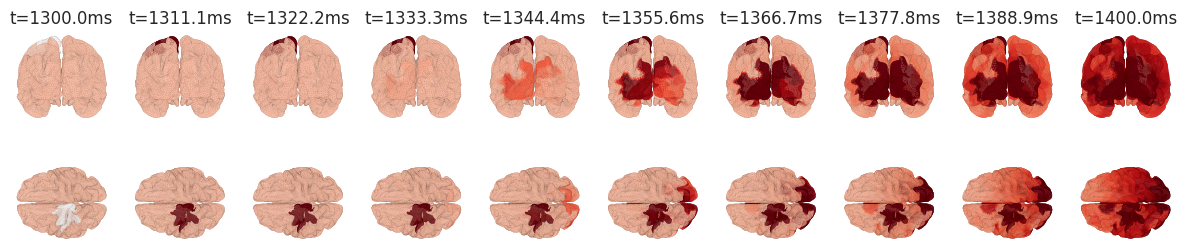

In [ ]:
fig, ax = plt.subplots(ncols=10, nrows=2,figsize=(15,3))
cmap = cm.Reds
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0.9, 'cmap': cmap,
       'vmax': 1.1, 'alpha': None, 'linewidth': 0.01}

ts = np.linspace(1300,1400,10)

for t_it,t in enumerate(ts):

    dat = df_norm.loc[t-5:t+5].mean(axis=0).values

    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=MNI_regmap,ax=ax[0][t_it],
                   shade_kwargs=kws,
                   view='rh_lat')

    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=MNI_regmap,ax=ax[1][t_it],
                   shade_kwargs=kws,
                   view='superior')


    ax[0][t_it].set_title('t=%1.1fms' %t)

## Conclusions

This collaborative notebook has provided a comprehensive exploration of:

-**Introducing neural mass modeling: **The notebook provided an introduction to neural mass modeling, a powerful technique for capturing the collective behavior of large populations of neurons.

- **Implementing single node dynamics in numpy and the Virtual Brain library:**
We successfully implemented the dynamics of a single node using numpy and the Virtual Brain library. This implementation allowed us to simulate and analyze the behavior of individual brain regions, providing insights into their functional dynamics.

- **Introducing connectivity between nodes for modeling brain activity at the whole-brain level:** Building upon the single node dynamics, we extended our modeling approach by incorporating connectivity between nodes. By considering the network of connections in the brain, we simulated and studied brain activity across multiple regions. This approach enabled us to explore the emergence of complex patterns and dynamics resulting from the interactions between different brain regions.


##References


> Ahmadizadeh S., Karoly PJ., Nešić D., Grayden DB, Cook MJ, Soudry D., Freestone DR. (2018) **Bifurcation analysis of two coupled Jansen-Rit neural mass models.** *PLoS One*, 13(3):e0192842. doi: 10.1371/journal.pone.0192842.

> Jansen, B.H. and Rit, V.G. (1995) **Electroencephalogram and visual evoked potential generation in a mathematical model of coupled cortical columns.** *Biological cybernetics*, 73(4), pp.357-366.

> Da Silva, F.L., Hoeks, A., Smits, H. and Zetterberg, L.H. (1974). **Model of brain rhythmic activity.** *Kybernetik*, 15(1), pp.27-37.

> David, O. and Friston, K.J. (2003) **A neural mass model for MEG/EEG: coupling and neuronal dynamics.** *NeuroImage*, 20(3), pp.1743-1755.

> Griffiths, J.D., Bastiaens SP., Kaboodvand N. (2022). **Whole-Brain Modelling: Past, Present, and Future.** *Adv Exp Med Biol*, 1359:313-355. doi: 10.1007/978-3-030-89439-9_13.

> Momi, D., Wang, Z., Griffiths, J.D. (2023). **TMS-Evoked Responses Are Driven by Recurrent Large-Scale Network Dynamics.** *eLife*, 111, pp.385-430.

> Schirner M., McIntosh AR., Jirsa V., Deco G., Ritter P.(2018). **Inferring multi-scale neural mechanisms with brain network modelling.** *eLife*, 7:e28927. doi:10.7554/eLife.28927.

> Spiegler, A., Knösche, T.R., Schwab, K., Haueisen, J. and Atay, F.M. (2011). **Modeling brain resonance phenomena using a neural mass model.** *PLoS Comput Biol*, 7(12), p.e1002298.

